In [1]:
import os
import torch
import pandas as pd
import numpy as np
import re
import ast
import json
from functools import reduce
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


**LOADING FILES**

**HEART**

In [2]:
# Define a function to load and process datasets
def load_and_process(file_path, embedding_col):
    df = pd.read_csv(file_path).rename(columns={'embedding': embedding_col}).drop_duplicates()
    df[embedding_col] = df[embedding_col].apply(lambda x: np.array(json.loads(x)))
    return df



# Process train data for each channel
train_fin = load_and_process('train_embeddings_long_axis_ch0_imbalanced_monai.csv', 'embedding0')
train_fin1 = load_and_process('train_embeddings_long_axis_ch1_imbalanced_monai.csv', 'embedding1')
train_fin2 = load_and_process('train_embeddings_long_axis_ch2_imbalanced_monai.csv', 'embedding2')

# Merge train DataFrames
train_df_x = pd.merge(train_fin, train_fin1, on=['image_path', 'label'], how='inner')
train_df_heart = pd.merge(train_df_x, train_fin2, on=['image_path', 'label'], how='inner')

# Extract IID from image path for train
train_df_heart['IID'] = train_df_heart['image_path'].str.extract(r'Processed/(\d+).npy').astype(int)

# Process test data for each channel
test_fin = load_and_process('test_embeddings_long_axis_ch0_imbalanced_monai.csv', 'embedding0')
test_fin1 = load_and_process('test_embeddings_long_axis_ch1_imbalanced_monai.csv', 'embedding1')
test_fin2 = load_and_process('test_embeddings_long_axis_ch2_imbalanced_monai.csv', 'embedding2')

# Merge test DataFrames
test_df_x = pd.merge(test_fin, test_fin1, on=['image_path', 'label'], how='inner')
test_df_heart = pd.merge(test_df_x, test_fin2, on=['image_path', 'label'], how='inner')

# Extract IID from image path for test
test_df_heart['IID'] = test_df_heart['image_path'].str.extract(r'Processed/(\d+).npy').astype(int)

# Print results (optional, for verification)
print(train_df_heart['label'].value_counts())
print(test_df_heart['label'].value_counts())

label
0    26358
1     4391
Name: count, dtype: int64
label
0    200
1    200
Name: count, dtype: int64


In [3]:
train_df_heart.head()

,image_path,embedding0,label,embedding1,embedding2,IID
0,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[0.7518877387046814, 1.1472522020339966, 0.815...",0,"[0.8113912343978882, 1.4069101810455322, 1.882...","[1.0720072984695435, 1.7625610828399658, 0.840...",2481857
1,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[0.6222007274627686, 0.857754111289978, 0.8616...",0,"[0.9138720631599426, 0.8331859707832336, 1.710...","[0.8524302840232849, 1.5004643201828003, 0.882...",3267458
2,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[1.0241048336029053, 1.4497884511947632, 1.037...",0,"[0.9310623407363892, 1.1488052606582642, 1.135...","[0.8256248831748962, 1.2329609394073486, 1.124...",3424201
3,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[0.8524421453475952, 1.1529635190963745, 0.927...",0,"[0.8691175580024719, 1.1014518737792969, 1.953...","[0.7155594825744629, 1.5444616079330444, 1.231...",4086644
4,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[0.8198446035385132, 1.0692479610443115, 0.942...",1,"[0.7523369193077087, 1.1102197170257568, 1.910...","[0.6888049840927124, 1.1276196241378784, 0.869...",4236006


In [5]:
# Define a function to load and process datasets
def load_and_process(file_path, embedding_col):
    df = pd.read_csv(file_path).rename(columns={'embedding': embedding_col}).drop_duplicates()
    df[embedding_col] = df[embedding_col].apply(lambda x: np.array(json.loads(x)))
    return df

# Process train and test datasets
train_df_blood_flow = load_and_process('train_embeddings_blood_flow_imbalanced_monai.csv', 'blood_flow_embeddings')
test_df_blood_flow = load_and_process('test_embeddings_blood_flow_imbalanced_monai.csv', 'blood_flow_embeddings')

# Extract IID from image path for both train and test
train_df_blood_flow['IID'] = train_df_blood_flow['image_path'].str.extract(r'/(\d+)_\d+_flow.npy').astype(int)
test_df_blood_flow['IID'] = test_df_blood_flow['image_path'].str.extract(r'/(\d+)_\d+_flow.npy').astype(int)

# Print results (optional, for verification)
print(train_df_blood_flow['label'].value_counts())
print(test_df_blood_flow['label'].value_counts())

label
0    26358
1     2971
Name: count, dtype: int64
label
0    200
1    200
Name: count, dtype: int64


In [6]:
train_df_blood_flow.head()

,image_path,blood_flow_embeddings,label,IID
0,/scratch/07880/devansh/CAD/FID20213_blood_flow...,"[0.6947618722915649, 1.4202600717544556, 0.696...",0,1642190
1,/scratch/07880/devansh/CAD/FID20213_blood_flow...,"[0.5132411122322083, 1.729156732559204, 0.7444...",0,3259474
2,/scratch/07880/devansh/CAD/FID20213_blood_flow...,"[0.6034924387931824, 1.744145154953003, 0.9753...",0,4028626
3,/scratch/07880/devansh/CAD/FID20213_blood_flow...,"[0.5624148845672607, 1.8594764471054077, 0.938...",0,2613106
4,/scratch/07880/devansh/CAD/FID20213_blood_flow...,"[0.834717869758606, 1.0795385837554932, 0.7549...",0,1483806


In [7]:
# Define a function to load and process datasets
def load_and_process(file_path, embedding_col):
    df = pd.read_csv(file_path).rename(columns={'embedding': embedding_col}).drop_duplicates()
    df[embedding_col] = df[embedding_col].apply(lambda x: np.array(json.loads(x)))
    return df

# Process train and test datasets
train_df_aortic = load_and_process('train_embeddings_aortic_monai.csv', 'aortic_embeddings')
test_df_aortic = load_and_process('test_embeddings_aortic_monai.csv', 'aortic_embeddings')

# Extract IID from image path for both train and test
train_df_aortic['IID'] = train_df_aortic['image_path'].str.extract(r'/(\d+)_\d+\.npy').astype(int)
test_df_aortic['IID'] = test_df_aortic['image_path'].str.extract(r'/(\d+)_\d+\.npy').astype(int)  # Fixed parentheses

# Print results (optional, for verification)
print(train_df_aortic['label'].value_counts())
print(test_df_aortic['label'].value_counts())

label
0    3287
1    3287
Name: count, dtype: int64
label
0    200
1    200
Name: count, dtype: int64


In [8]:
# Define a function to load and process datasets
def load_and_process(file_path, embedding_col, iid_pattern):
    """
    Load, rename columns, and extract IID from the image path.

    :param file_path: Path to the CSV file.
    :param embedding_col: Name to assign to the embedding column.
    :param iid_pattern: Regex pattern to extract IID from the image path.
    :return: Processed DataFrame with IID extracted.
    """
    df = pd.read_csv(file_path).rename(columns={'embedding': embedding_col})
    df[embedding_col] = df[embedding_col].apply(lambda x: np.array(json.loads(x)))
    df['IID'] = df['image_path'].str.extract(iid_pattern).astype(int)
    return df.drop_duplicates(subset=['IID']).reset_index(drop=True)

# Liver data processing
train_liver = load_and_process(
    'train_embeddings_liver_nov_imbalanced.csv', 
    'embedding_liver', 
    r'/(\d+)\.jpg$'
)

test_liver = load_and_process(
    'test_embeddings_liver_nov.csv', 
    'embedding_liver', 
    r'/(\d+)\.jpg$'
)

# Pancreas data processing
train_pan = load_and_process(
    'train_embeddings_pancreas_nov_imbalanced.csv', 
    'embedding_pan', 
    r'/(\d+)_\d+\.jpg$'
)

test_pan = load_and_process(
    'test_embeddings_pancreas_nov.csv', 
    'embedding_pan', 
    r'/(\d+)_\d+\.jpg$'
)

# Optional: Print duplicate checks for verification
print('Liver Test IID Duplicates:', test_liver['IID'].duplicated().sum())
print('Pancreas Test IID Duplicates:', test_pan['IID'].duplicated().sum())

# Print label value counts for verification
print("\nTrain Liver Label Counts:")
print(train_liver['label'].value_counts())
print("\nTest Liver Label Counts:")
print(test_liver['label'].value_counts())
print("\nTrain Pancreas Label Counts:")
print(train_pan['label'].value_counts())
print("\nTest Pancreas Label Counts:")
print(test_pan['label'].value_counts())

Liver Test IID Duplicates: 0
Pancreas Test IID Duplicates: 0

Train Liver Label Counts:
label
0    26358
1     4342
Name: count, dtype: int64

Test Liver Label Counts:
label
0    200
1    200
Name: count, dtype: int64

Train Pancreas Label Counts:
label
0    26358
1     3495
Name: count, dtype: int64

Test Pancreas Label Counts:
label
0    200
1    200
Name: count, dtype: int64


In [9]:
train_liver.head()

,image_path,embedding_liver,label,IID
0,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.048257745802402496, 0.17932827770709991, 0....",0,2283985
1,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.49649253487586975, 0.5446419715881348, 0.33...",0,1414804
2,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.4503157436847687, 0.25143322348594666, 0.34...",0,2008383
3,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.454449325799942, 0.22551193833351135, 0.306...",0,4557403
4,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.2629716396331787, 0.30035993456840515, 0.20...",1,5959204


In [10]:
len(train_liver['embedding_liver'][0])

2048

In [11]:
train_pan.head()

,image_path,embedding_pan,label,IID
0,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.08376840502023697, 0.23182588815689087, 0.4...",0,1278310
1,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.12229117006063461, 0.16631604731082916, 0.4...",1,1438790
2,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.1899460107088089, 0.25007355213165283, 0.39...",0,3658572
3,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.3096292316913605, 0.254027783870697, 0.3932...",0,4630519
4,/corral-repl/utexas/UKB-Imaging-Genetics/Imagi...,"[0.3899383842945099, 0.5091740489006042, 0.243...",0,2530973


In [12]:
# Define a function to load and process datasets
def load_and_process(file_path, embedding_col, iid_pattern):
    """
    Load, rename columns, and extract IID from the image path.

    :param file_path: Path to the CSV file.
    :param embedding_col: Name to assign to the embedding column.
    :param iid_pattern: Regex pattern to extract IID from the image path.
    :return: Processed DataFrame with IID extracted.
    """
    df = pd.read_csv(file_path).rename(columns={'embedding': embedding_col})
    df['IID'] = df['image_path'].str.extract(iid_pattern).astype(int)
    return df.drop_duplicates(subset=['IID']).reset_index(drop=True)

# DXA data processing
train_dxa = load_and_process(
    'train_embeddings_dxa_nov_imbalanced.csv', 
    'embedding_dxa', 
    r'/(\d+)_\d+_\d+_\d+/.*\.dcm$'
)

test_dxa = load_and_process(
    'test_embeddings_dxa_nov.csv', 
    'embedding_dxa', 
    r'/(\d+)_\d+_\d+_\d+/.*\.dcm$'
)

# Optional: Print duplicate checks for verification
print('DXA Test IID Duplicates:', test_dxa['IID'].duplicated().sum())

# Print label value counts for verification
print("\nTrain DXA Label Counts:")
print(train_dxa['label'].value_counts())
print("\nTest DXA Label Counts:")
print(test_dxa['label'].value_counts())

DXA Test IID Duplicates: 0

Train DXA Label Counts:
label
0    26358
1     4335
Name: count, dtype: int64

Test DXA Label Counts:
label
0    200
1    200
Name: count, dtype: int64


In [13]:
train_dxa.head()

,image_path,embedding_dxa,label,IID
0,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[0.5542763471603394, 0.6572828888893127, 0.410...",1,5391558
1,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[0.5313587188720703, 0.8718631863594055, 0.446...",1,6004488
2,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[0.3109695315361023, 0.35504278540611267, 1.00...",0,2000280
3,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[0.2871086001396179, 0.19473133981227875, 1.20...",0,1444850
4,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,"[0.653364896774292, 0.3951607346534729, 1.5138...",1,2286513


In [14]:
train_ecg = pd.read_csv('Final_Datasets/train_imbalanced_ecg.csv')
train_ecg = train_ecg.rename(columns = {'CAD':'label'})
train_ecg.head()

,FilePath_ECG,IID,label,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude
0,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,4465837,1,78.0,376.0,431.0,754.0,755.0,302.500000,339.583333,185.400000
1,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,4611362,1,78.0,404.0,423.0,908.0,905.0,336.500000,562.000000,125.416667
2,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,4032904,1,96.0,398.0,429.0,862.0,855.0,45.333333,574.833333,104.250000
3,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,5099267,1,132.0,440.0,471.0,868.0,865.0,854.000000,319.555556,175.750000
4,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,3910439,1,78.0,354.0,430.0,676.0,670.0,104.285714,515.666667,127.583333


In [15]:
# List of datasets to merge sequentially
datasets = [
    train_df_heart,
    train_df_blood_flow,
    train_df_aortic,
    train_liver,
    train_pan,
    train_ecg,
    train_dxa
]

# Drop the 'image path' column if it exists in any dataset
datasets = [df.drop(columns=['image_path'], errors='ignore') for df in datasets]


train_df_full = reduce(lambda left, right: pd.merge(left, right, on=['IID', 'label'], how='inner'), datasets)

# Display the resulting dataframe
train_df_full.head()

,embedding0,label,embedding1,embedding2,IID,blood_flow_embeddings,aortic_embeddings,embedding_liver,embedding_pan,FilePath_ECG,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,embedding_dxa
0,"[0.6222007274627686, 0.857754111289978, 0.8616...",0,"[0.9138720631599426, 0.8331859707832336, 1.710...","[0.8524302840232849, 1.5004643201828003, 0.882...",3267458,"[0.49880194664001465, 1.4803217649459839, 0.88...","[1.099939227104187, 0.8363233208656311, 0.7002...","[0.4189172685146332, 0.30685412883758545, 0.37...","[0.27812063694000244, 0.28674405813217163, 0.3...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,74.0,426.0,396.0,1146.0,1150.0,32.800000,529.166667,251.500000,"[0.6558697819709778, 0.5402312874794006, 1.598..."
1,"[0.8524421453475952, 1.1529635190963745, 0.927...",0,"[0.8691175580024719, 1.1014518737792969, 1.953...","[0.7155594825744629, 1.5444616079330444, 1.231...",4086644,"[0.4786435663700104, 2.13521146774292, 1.06172...","[1.517000436782837, 0.8485708832740784, 0.7001...","[0.19374282658100128, 0.342273086309433, 0.303...","[0.22225554287433624, 0.537835955619812, 0.208...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,90.0,418.0,438.0,914.0,905.0,45.200000,683.083333,163.250000,"[0.15378202497959137, 0.2685377597808838, 1.19..."
2,"[0.8198446035385132, 1.0692479610443115, 0.942...",1,"[0.7523369193077087, 1.1102197170257568, 1.910...","[0.6888049840927124, 1.1276196241378784, 0.869...",4236006,"[0.6126276850700378, 1.3475338220596313, 0.886...","[0.8442996144294739, 0.659028172492981, 0.6841...","[0.3939160108566284, 0.3585018813610077, 0.438...","[0.11313962936401367, 0.5041405558586121, 0.10...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,76.0,400.0,372.0,1152.0,1150.0,752.666667,714.000000,210.416667,"[0.26467379927635193, 0.391009122133255, 1.596..."
3,"[0.6215686202049255, 0.9250015020370483, 0.959...",0,"[0.6947037577629089, 1.1452747583389282, 1.401...","[0.9793095588684082, 1.412980079650879, 0.7921...",2003477,"[0.7195608615875244, 1.3613497018814087, 0.770...","[1.0216706991195679, 0.6351988315582275, 0.909...","[0.3911161422729492, 0.2766222655773163, 0.609...","[0.3104081153869629, 0.21548178791999817, 0.68...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,92.0,442.0,422.0,1094.0,1090.0,65.500000,591.166667,339.500000,"[0.4735870659351349, 0.2527642548084259, 1.111..."
4,"[0.5215746164321899, 1.1620604991912842, 0.858...",0,"[0.6306257247924805, 1.0514334440231323, 1.562...","[1.0788642168045044, 2.0992400646209717, 0.792...",1817039,"[0.5923391580581665, 1.4759345054626465, 0.664...","[1.4068950414657593, 0.7599076628684998, 0.730...","[0.35237616300582886, 0.6358820199966431, 0.55...","[0.43284040689468384, 0.33511728048324585, 0.3...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,94.0,442.0,469.0,884.0,880.0,210.500000,504.583333,72.454545,"[0.5180872082710266, 0.3238743841648102, 1.071..."


In [16]:
train_df_full['label'].value_counts()

label
0    2685
1    2182
Name: count, dtype: int64

In [17]:
# List of test datasets to merge sequentially
test_datasets = [
    test_df_heart,
    test_liver,
    test_pan,
    test_df_blood_flow,
    test_dxa,
    test_df_aortic
]

# Drop the 'image path' column if it exists in any dataset
test_datasets = [df.drop(columns=['image_path'], errors='ignore') for df in test_datasets]

test_df_full = reduce(lambda left, right: pd.merge(left, right, on=['IID', 'label'], how='inner'), test_datasets)

# Display the resulting dataframe
test_df_full.head()

,embedding0,label,embedding1,embedding2,IID,embedding_liver,embedding_pan,blood_flow_embeddings,embedding_dxa,aortic_embeddings
0,"[1.0895754098892212, 1.2075629234313965, 1.048...",0,"[0.5463781356811523, 0.9533547163009644, 1.702...","[1.0024220943450928, 1.2877448797225952, 1.076...",4890586,"[0.10730624198913574, 0.3022737503051758, 0.35...","[0.05167745053768158, 0.31272897124290466, 0.2...","[0.6833826303482056, 1.6826467514038086, 1.155...","[0.34417498111724854, 0.35010382533073425, 1.2...","[1.4666997194290161, 0.8146945238113403, 0.733..."
1,"[0.7500353455543518, 0.5545405745506287, 0.863...",0,"[0.8292922973632812, 0.8665534853935242, 1.341...","[0.7049407958984375, 0.8878511786460876, 0.806...",2201189,"[0.3628007769584656, 0.2414785474538803, 0.325...","[0.340436190366745, 0.5034552216529846, 0.2665...","[0.6690220832824707, 1.3973817825317383, 1.121...","[0.2703787684440613, 0.3391417860984802, 1.129...","[1.750013828277588, 0.7056908011436462, 0.6797..."
2,"[0.7465672492980957, 1.0462931394577026, 0.827...",1,"[0.8891360759735107, 0.7426362037658691, 1.191...","[0.9128535389900208, 0.8650694489479065, 0.742...",3646967,"[0.20753838121891022, 0.2378999888896942, 0.18...","[0.1403672993183136, 0.6075150370597839, 0.290...","[0.539034903049469, 1.6345493793487549, 1.2556...","[0.504126787185669, 0.7670823335647583, 0.7953...","[1.196069598197937, 0.8318781852722168, 0.6023..."
3,"[1.2226277589797974, 2.3310561180114746, 1.097...",0,"[0.6006484627723694, 1.6089153289794922, 2.282...","[1.2725563049316406, 1.6649129390716553, 1.630...",2032754,"[0.3206886947154999, 0.30404040217399597, 0.55...","[0.3354561924934387, 0.3207063674926758, 0.536...","[0.49320709705352783, 2.03706955909729, 1.3409...","[0.5785273909568787, 0.5770753622055054, 1.232...","[1.711975336074829, 0.9903967380523682, 0.5838..."
4,"[1.1025010347366333, 1.4001193046569824, 0.854...",1,"[0.9131760597229004, 0.6301987767219543, 1.686...","[0.8072603940963745, 1.216403841972351, 1.0066...",2434644,"[0.17730797827243805, 0.3730643689632416, 0.24...","[0.22302202880382538, 0.5957054495811462, 0.30...","[0.6274088621139526, 1.3032548427581787, 0.985...","[0.5364879965782166, 0.5445913672447205, 1.279...","[0.9530894160270691, 0.9407976865768433, 0.623..."


In [18]:
test_df_full['label'].value_counts()

label
0    200
1    200
Name: count, dtype: int64

**HELPER FUNCTIONS**

In [19]:
def convert_to_array(embedding):
    """
    Converts a string representation of a list into a NumPy array.
    
    Args:
        embedding (str or list): Embedding to convert.
        
    Returns:
        np.ndarray: Converted embedding.
    """
    if isinstance(embedding, str):
        return np.array(ast.literal_eval(embedding))  # Safely parse string to list
    elif isinstance(embedding, (list, np.ndarray)):
        return np.array(embedding)
    else:
        raise ValueError(f"Unsupported embedding format: {type(embedding)}")

In [20]:
def fit_pca_on_train(df, embedding_cols, n_components=10):
    """
    Fits PCA on the train embeddings and adds PCA-transformed features to the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the embeddings.
        embedding_cols (list of str): Column names with embeddings.
        n_components (int): Number of PCA components to fit.

    Returns:
        tuple: Updated DataFrame with PCA features and a dictionary of fitted PCA objects.
    """
    pca_dict = {}
    for col in embedding_cols:
        # Ensure the embeddings are numpy arrays
        embeddings = np.vstack(df[col].values)
        
        # Fit PCA
        pca = PCA(n_components=n_components)
        pca.fit(embeddings)
        pca_dict[col] = pca
        
        # Transform and add PCA features to the DataFrame
        pca_features = pca.transform(embeddings)
        pca_feature_cols = [f'pca_{col}_{i+1}' for i in range(n_components)]
        df[pca_feature_cols] = pca_features
    
    return df, pca_dict

In [21]:
def transform_embeddings_with_pca(df, embedding_cols, pca_dict):
    """
    Transforms embeddings using pre-fitted PCA and adds PCA features to the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the embeddings to transform.
        embedding_cols (list of str): Column names with embeddings.
        pca_dict (dict): Dictionary of pre-fitted PCA objects for each column.

    Returns:
        pd.DataFrame: Updated DataFrame with PCA-transformed features added.
    """
    for col in embedding_cols:
        # Ensure the embeddings are numpy arrays
        embeddings = np.vstack(df[col].values)
        
        # Transform using the pre-fitted PCA
        pca = pca_dict[col]
        pca_features = pca.transform(embeddings)
        
        # Add PCA features to the DataFrame
        pca_feature_cols = [f'pca_{col}_{i+1}' for i in range(pca.n_components)]
        df[pca_feature_cols] = pca_features
    
    return df

In [22]:
train_df_full.columns

Index(['embedding0', 'label', 'embedding1', 'embedding2', 'IID',
       'blood_flow_embeddings', 'aortic_embeddings', 'embedding_liver',
       'embedding_pan', 'FilePath_ECG', 'QRSDuration', 'QTInterval',
       'QTCInterval', 'RRInterval', 'PPInterval', 'MeanQAmplitude',
       'MeanRAmplitude', 'MeanTAmplitude', 'embedding_dxa'],
      dtype='object')

In [23]:
# Embedding Columns and PCA
embedding_columns = [
    'embedding0', 
    'embedding1', 
    'embedding2', 
    'embedding_liver', 
    'embedding_pan', 
    'embedding_dxa',
    'blood_flow_embeddings',
    'aortic_embeddings'
    
]
# Convert all embeddings to NumPy arrays
for col in embedding_columns:
    train_df_full[col] = train_df_full[col].apply(convert_to_array)

# Perform PCA on the embedding columns
train_df_full, pca_dict = fit_pca_on_train(train_df_full, embedding_columns)


# Generate PCA columns dynamically
pca_columns = [f'pca_{col}_{i+1}' for col in embedding_columns for i in range(10)]

# Select relevant columns for analysis
columns_to_keep = [
    'IID', 'label', 'QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval',
    'PPInterval', 'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude'
] + pca_columns
train_df = train_df_full[columns_to_keep]

In [24]:
train_df.head()

,IID,label,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,...,pca_aortic_embeddings_1,pca_aortic_embeddings_2,pca_aortic_embeddings_3,pca_aortic_embeddings_4,pca_aortic_embeddings_5,pca_aortic_embeddings_6,pca_aortic_embeddings_7,pca_aortic_embeddings_8,pca_aortic_embeddings_9,pca_aortic_embeddings_10
0,3267458,0,74.0,426.0,396.0,1146.0,1150.0,32.800000,529.166667,251.500000,...,0.444553,-2.443634,-0.747737,-0.065891,-0.071616,0.212179,-0.160254,0.472344,-0.103605,0.070745
1,4086644,0,90.0,418.0,438.0,914.0,905.0,45.200000,683.083333,163.250000,...,10.710984,-1.684581,1.162048,-0.099025,0.749966,-0.390027,-0.035465,0.416090,0.191582,0.118591
2,4236006,1,76.0,400.0,372.0,1152.0,1150.0,752.666667,714.000000,210.416667,...,-5.019111,-2.411748,0.186028,-0.156459,-0.107128,0.059886,-0.025756,-0.554699,-0.075979,0.186695
3,2003477,0,92.0,442.0,422.0,1094.0,1090.0,65.500000,591.166667,339.500000,...,-6.165969,-3.174090,-0.311205,-0.091290,0.248883,0.430574,-0.329403,0.340376,-0.324655,-0.094957
4,1817039,0,94.0,442.0,469.0,884.0,880.0,210.500000,504.583333,72.454545,...,9.496227,-2.925347,0.336540,-0.679101,0.565614,-0.368200,-0.171376,0.298047,0.338799,0.145813


In [25]:
# import matplotlib.pyplot as plt

# def plot_first_two_pcs(train_df, pca_dict, embedding_columns, label_column='label'):
#     """
#     Plots the first two principal components (PCs) for each embedding type,
#     with points colored based on the label (0: no CAD, 1: CAD).

#     Args:
#         train_df (pd.DataFrame): DataFrame containing PCA-transformed columns.
#         pca_dict (dict): Dictionary containing fitted PCA models for each embedding type.
#         embedding_columns (list of str): List of embedding column names.
#         label_column (str): Column name for the label used for coloring the points.
#     """
#     for col in embedding_columns:
#         pca_cols = [f'pca_{col}_1', f'pca_{col}_2']
#         plt.figure(figsize=(8, 6))
        
#         # Scatter plot of the first two PCs, colored by label
#         for label in train_df[label_column].unique():
#             subset = train_df[train_df[label_column] == label]
#             plt.scatter(subset[pca_cols[0]], subset[pca_cols[1]], 
#                         label=f'CAD={label}', alpha=0.6)
        
#         # Plot formatting
#         plt.title(f'First Two Principal Components - {col}', fontsize=14)
#         plt.xlabel('PC1', fontsize=12)
#         plt.ylabel('PC2', fontsize=12)
#         plt.legend()
#         plt.grid(True, alpha=0.3)
#         plt.show()

# # Example Usage
# embedding_columns_for_plot = ['embedding_dxa']  # Only plot for heart embeddings
# plot_first_two_pcs(train_df_full, pca_dict, embedding_columns_for_plot)

In [26]:
# PRS
prs = pd.read_csv('prs_output_CAD_PRS_new.txt', sep='\t')
prs = prs.rename(columns={'SCORE1_SUM': 'PRS'})[['IID', 'PRS']]
train = pd.merge(train_df, prs, on='IID', how='inner')

# TNSI
tnsi = pd.read_csv('../fid22189.csv').rename(columns={'eid': 'IID', '22189-0.0': 'tnsi'})[['IID', 'tnsi']]
train = pd.merge(train, tnsi, on='IID', how='inner')

# Income
income = pd.read_csv('../fid738.csv').rename(columns={'eid': 'IID', '738-0.0': 'income'})[['IID', 'income']]
train = pd.merge(train, income, on='IID', how='inner')

# Age
age = pd.read_csv('../fid21003.csv').rename(columns={'eid': 'IID', '21003-2.0': 'age'})[['IID', 'age']]
train = pd.merge(train, age, on='IID', how='inner')

# Sex
sex = pd.read_csv('../fid31.csv').rename(columns={'eid': 'IID', '31-0.0': 'sex'})[['IID', 'sex']]
train = pd.merge(train, sex, on='IID', how='inner')

# BMI
bmi = pd.read_csv('../fid21001.csv').rename(columns={'eid': 'IID', '21001-0.0': 'bmi'})[['IID', 'bmi']]
train = pd.merge(train, bmi, on='IID', how='inner')

# LDL
ldl = pd.read_csv('../fid30780.csv').rename(columns={'eid': 'IID', '30780-0.0': 'ldl'})[['IID', 'ldl']]
train = pd.merge(train, ldl, on='IID', how='inner')

# Triglycerides
trig = pd.read_csv('../fid30870.csv').rename(columns={'eid': 'IID', '30870-0.0': 'trig'})[['IID', 'trig']]
train = pd.merge(train, trig, on='IID', how='inner')

# Total Cholesterol
tc = pd.read_csv('../fid30690.csv').rename(columns={'eid': 'IID', '30690-0.0': 'total_cholestrol'})[['IID', 'total_cholestrol']]
train = pd.merge(train, tc, on='IID', how='inner')

# Smoking
smoking = pd.read_csv('../fid20116.csv').rename(columns={'eid': 'IID', '20116-0.0': 'smoking'})[['IID', 'smoking']]
train = pd.merge(train, smoking, on='IID', how='inner')

# BP Diastolic
bpd = pd.read_csv('../fid4079.csv')
bpd['4079-0.0'] = bpd['4079-0.0'].combine_first(bpd['4079-2.0'])
bpd = bpd.rename(columns={'eid': 'IID', '4079-0.0': 'bp_dia'})[['IID', 'bp_dia']]
train = pd.merge(train, bpd, on='IID', how='inner')

# BP Systolic
bps = pd.read_csv('../fid4080.csv')
bps['4080-0.0'] = bps['4080-0.0'].combine_first(bps['4080-2.0'])
bps = bps.rename(columns={'eid': 'IID', '4080-0.0': 'bp_sys'})[['IID', 'bp_sys']]
train = pd.merge(train, bps, on='IID', how='inner')

# Pulse Rate
pr = pd.read_csv('../fid102.csv')
pr['102-0.0'] = pr['102-0.0'].combine_first(pr['102-2.0'])
pr = pr.rename(columns={'eid': 'IID', '102-0.0': 'pulse_rate'})[['IID', 'pulse_rate']]
train = pd.merge(train, pr, on='IID', how='inner')

print(train.isnull().sum())

train = train.dropna()
print(train['label'].value_counts())
train.head()

IID                   0
label                 0
QRSDuration           0
QTInterval            0
QTCInterval           0
                   ... 
total_cholestrol    108
smoking               0
bp_dia               38
bp_sys               38
pulse_rate           38
Length: 103, dtype: int64
label
0    2681
1    2057
Name: count, dtype: int64


,IID,label,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,...,age,sex,bmi,ldl,trig,total_cholestrol,smoking,bp_dia,bp_sys,pulse_rate
0,3267458,0,74.0,426.0,396.0,1146.0,1150.0,32.800000,529.166667,251.500000,...,61.0,1,20.5966,1.947,0.827,3.737,0.0,87.0,136.0,71.0
1,4086644,0,90.0,418.0,438.0,914.0,905.0,45.200000,683.083333,163.250000,...,67.0,0,21.6128,2.917,1.406,5.806,1.0,60.0,107.0,63.0
2,4236006,1,76.0,400.0,372.0,1152.0,1150.0,752.666667,714.000000,210.416667,...,65.0,1,23.9635,4.659,2.548,7.295,0.0,101.0,158.0,55.0
3,2003477,0,92.0,442.0,422.0,1094.0,1090.0,65.500000,591.166667,339.500000,...,58.0,0,19.4213,2.249,0.815,4.011,0.0,71.0,110.0,61.0
4,1817039,0,94.0,442.0,469.0,884.0,880.0,210.500000,504.583333,72.454545,...,69.0,0,21.0381,3.640,0.791,6.083,1.0,79.0,159.0,75.0


**DISEASE STATUS**

In [27]:
dm = pd.read_csv('dm_case_control.csv')
train = pd.merge(train, dm, on='IID', how='inner')

ht = pd.read_csv('ht_case_control.csv')
train = pd.merge(train, ht, on='IID', how='inner')

hl = pd.read_csv('hl_case_control.csv')
train = pd.merge(train, hl, on='IID', how='inner')

train['label'].value_counts()

label
0    2681
1    2057
Name: count, dtype: int64

In [28]:
test_df_full.head()

,embedding0,label,embedding1,embedding2,IID,embedding_liver,embedding_pan,blood_flow_embeddings,embedding_dxa,aortic_embeddings
0,"[1.0895754098892212, 1.2075629234313965, 1.048...",0,"[0.5463781356811523, 0.9533547163009644, 1.702...","[1.0024220943450928, 1.2877448797225952, 1.076...",4890586,"[0.10730624198913574, 0.3022737503051758, 0.35...","[0.05167745053768158, 0.31272897124290466, 0.2...","[0.6833826303482056, 1.6826467514038086, 1.155...","[0.34417498111724854, 0.35010382533073425, 1.2...","[1.4666997194290161, 0.8146945238113403, 0.733..."
1,"[0.7500353455543518, 0.5545405745506287, 0.863...",0,"[0.8292922973632812, 0.8665534853935242, 1.341...","[0.7049407958984375, 0.8878511786460876, 0.806...",2201189,"[0.3628007769584656, 0.2414785474538803, 0.325...","[0.340436190366745, 0.5034552216529846, 0.2665...","[0.6690220832824707, 1.3973817825317383, 1.121...","[0.2703787684440613, 0.3391417860984802, 1.129...","[1.750013828277588, 0.7056908011436462, 0.6797..."
2,"[0.7465672492980957, 1.0462931394577026, 0.827...",1,"[0.8891360759735107, 0.7426362037658691, 1.191...","[0.9128535389900208, 0.8650694489479065, 0.742...",3646967,"[0.20753838121891022, 0.2378999888896942, 0.18...","[0.1403672993183136, 0.6075150370597839, 0.290...","[0.539034903049469, 1.6345493793487549, 1.2556...","[0.504126787185669, 0.7670823335647583, 0.7953...","[1.196069598197937, 0.8318781852722168, 0.6023..."
3,"[1.2226277589797974, 2.3310561180114746, 1.097...",0,"[0.6006484627723694, 1.6089153289794922, 2.282...","[1.2725563049316406, 1.6649129390716553, 1.630...",2032754,"[0.3206886947154999, 0.30404040217399597, 0.55...","[0.3354561924934387, 0.3207063674926758, 0.536...","[0.49320709705352783, 2.03706955909729, 1.3409...","[0.5785273909568787, 0.5770753622055054, 1.232...","[1.711975336074829, 0.9903967380523682, 0.5838..."
4,"[1.1025010347366333, 1.4001193046569824, 0.854...",1,"[0.9131760597229004, 0.6301987767219543, 1.686...","[0.8072603940963745, 1.216403841972351, 1.0066...",2434644,"[0.17730797827243805, 0.3730643689632416, 0.24...","[0.22302202880382538, 0.5957054495811462, 0.30...","[0.6274088621139526, 1.3032548427581787, 0.985...","[0.5364879965782166, 0.5445913672447205, 1.279...","[0.9530894160270691, 0.9407976865768433, 0.623..."


In [29]:
# Define embedding columns for PCA
embedding_columns = [
    'embedding0', 
    'embedding1', 
    'embedding2', 
    'embedding_liver', 
    'embedding_pan', 
    'embedding_dxa',
    'blood_flow_embeddings',
    'aortic_embeddings'
]

# Convert all embeddings to NumPy arrays
for col in embedding_columns:
    test_df_full[col] = test_df_full[col].apply(convert_to_array)


# Perform PCA on embeddings and add PCA columns to the test DataFrame
test_df_full, pca_dict = fit_pca_on_train(test_df_full, embedding_columns, n_components=10)

# Generate PCA column names dynamically
pca_columns = [f'pca_{col}_{i+1}' for col in embedding_columns for i in range(10)]

# Extract only necessary columns for the next steps
test_df_full = test_df_full[['IID', 'label'] + pca_columns]
test_df_full.head()

,IID,label,pca_embedding0_1,pca_embedding0_2,pca_embedding0_3,pca_embedding0_4,pca_embedding0_5,pca_embedding0_6,pca_embedding0_7,pca_embedding0_8,...,pca_aortic_embeddings_1,pca_aortic_embeddings_2,pca_aortic_embeddings_3,pca_aortic_embeddings_4,pca_aortic_embeddings_5,pca_aortic_embeddings_6,pca_aortic_embeddings_7,pca_aortic_embeddings_8,pca_aortic_embeddings_9,pca_aortic_embeddings_10
0,4890586,0,0.631282,2.211253,1.092452,-0.389791,0.228801,-0.114441,0.089966,0.783760,...,2.933953,0.256624,-0.064048,-0.589980,-0.456735,-0.866546,-0.660042,0.446198,-0.424931,0.910662
1,2201189,0,-4.278456,-3.219499,1.083042,0.208104,0.634663,0.242872,1.013957,0.221977,...,3.779756,0.600090,0.984906,-0.695781,-0.073313,0.411269,0.047788,0.182227,-0.495107,0.361958
2,3646967,1,-1.817479,2.961022,-0.267553,0.177391,-0.689986,0.263159,-0.042834,0.194144,...,-5.964573,2.459319,-0.487542,0.448770,0.135193,0.124955,0.378512,0.286189,-0.053506,0.259189
3,2032754,0,11.592997,0.554648,-1.872902,0.147680,-0.818226,0.165171,0.008931,-0.379519,...,6.898371,5.500584,0.189823,0.091907,-0.024012,1.011828,0.288101,1.205563,-0.307809,0.055333
4,2434644,1,1.188136,3.451512,0.248981,0.382047,0.785416,-0.005961,-0.994316,-0.310175,...,-4.770036,0.635844,0.723621,-0.009184,0.328071,-0.014202,0.116707,0.148294,0.235149,0.070876


In [30]:
test_df_full['label'].value_counts()

label
0    200
1    200
Name: count, dtype: int64

In [57]:
test_df_full.iloc[:5, 40:45]

,pca_embedding_liver_9,pca_embedding_liver_10,pca_embedding_pan_1,pca_embedding_pan_2,pca_embedding_pan_3
0,-2.379780,0.468216,-0.773003,4.214201,-2.015964
1,0.585751,-0.726700,-1.723844,0.666039,2.699272
2,-0.319557,0.155029,-2.576441,2.493005,2.465454
3,-0.212738,-1.342065,-1.336325,1.055057,1.925827
4,2.288112,1.494207,-1.539799,-0.319702,2.574492


In [31]:
test_new = pd.read_csv('Final_Datasets/test_incidence_new.csv')
test_new = test_new[['IID', 'age', 'sex','bmi', 'ldl', 'total_cholestrol', 'trig', 'smoking', 'bp_dia', 'bp_sys',
       'pulse_rate', 'QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval',
       'PPInterval', 'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude']]

# PRS
prs = pd.read_csv('prs_output_CAD_PRS_new.txt', sep='\t')
prs = prs.rename(columns={'SCORE1_SUM': 'PRS'})[['IID', 'PRS']]
test_new = pd.merge(test_new, prs, on='IID', how='inner')

# TNSI
tnsi = pd.read_csv('../fid22189.csv').rename(columns={'eid': 'IID', '22189-0.0': 'tnsi'})[['IID', 'tnsi']]
test_new = pd.merge(test_new, tnsi, on='IID', how='inner')

# Income
income = pd.read_csv('../fid738.csv').rename(columns={'eid': 'IID', '738-0.0': 'income'})[['IID', 'income']]
test_new = pd.merge(test_new, income, on='IID', how='inner')

In [32]:
test_new.head()

,IID,age,sex,bmi,ldl,total_cholestrol,trig,smoking,bp_dia,bp_sys,...,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,PRS,tnsi,income
0,1423285,62.0,0,27.5877,4.355,6.601,0.6858,2.0,73.0,150.0,...,392.0,469.0,698.0,695.0,63.000000,641.250000,201.000000,-7.65394,-3.98,1.0
1,1063876,54.0,1,25.6831,4.549,6.154,0.2438,2.0,82.0,160.0,...,432.0,434.0,980.0,980.0,193.166667,914.250000,254.833333,-6.35300,0.84,-3.0
2,5501540,59.0,0,25.0292,2.710,4.773,0.2898,0.0,78.0,123.0,...,396.0,442.0,796.0,800.0,141.000000,380.083333,153.250000,-9.39003,-5.09,4.0
3,2604649,59.0,0,20.9402,2.823,5.033,0.2312,0.0,96.0,149.0,...,448.0,450.0,986.0,980.0,180.333333,467.916667,243.833333,-6.33580,-4.57,3.0
4,3441260,75.0,1,26.6981,3.643,5.685,0.2004,0.0,92.0,155.0,...,498.0,415.0,1440.0,1175.0,142.500000,425.500000,95.500000,-7.71181,-0.80,4.0


In [33]:
test = pd.merge(test_df_full, test_new, on = 'IID', how = 'inner')

**DISEASE STATUS**

In [34]:
dm = pd.read_csv('dm_case_control.csv')
test = pd.merge(test, dm, on='IID', how='inner')

ht = pd.read_csv('ht_case_control.csv')
test = pd.merge(test, ht, on='IID', how='inner')

hl = pd.read_csv('hl_case_control.csv')
test = pd.merge(test, hl, on='IID', how='inner')

test['label'].value_counts()

label
0    200
1    200
Name: count, dtype: int64

In [35]:
test.head()

,IID,label,pca_embedding0_1,pca_embedding0_2,pca_embedding0_3,pca_embedding0_4,pca_embedding0_5,pca_embedding0_6,pca_embedding0_7,pca_embedding0_8,...,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,PRS,tnsi,income,DM,HT,HL
0,4890586,0,0.631282,2.211253,1.092452,-0.389791,0.228801,-0.114441,0.089966,0.783760,...,1250.0,67.833333,874.750000,110.416667,-7.49033,-5.71,4.0,0,0,0
1,2201189,0,-4.278456,-3.219499,1.083042,0.208104,0.634663,0.242872,1.013957,0.221977,...,980.0,120.833333,801.083333,287.416667,-8.12347,1.80,2.0,0,1,0
2,3646967,1,-1.817479,2.961022,-0.267553,0.177391,-0.689986,0.263159,-0.042834,0.194144,...,965.0,329.000000,356.416667,202.916667,-5.88483,0.00,-3.0,0,1,0
3,2032754,0,11.592997,0.554648,-1.872902,0.147680,-0.818226,0.165171,0.008931,-0.379519,...,905.0,230.666667,472.416667,140.833333,-9.03647,-1.04,3.0,0,0,0
4,2434644,1,1.188136,3.451512,0.248981,0.382047,0.785416,-0.005961,-0.994316,-0.310175,...,1130.0,270.500000,1020.833333,475.833333,-8.19462,-4.09,4.0,0,1,0


In [36]:
test['label'].value_counts()

label
0    200
1    200
Name: count, dtype: int64

In [46]:
center = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid54.csv').rename(columns={'eid': 'IID', '54-2.0': 'center'})[['IID', 'center']]
center = center.dropna()
center.head()

,IID,center
1,1000026,11027.0
23,1000245,11025.0
26,1000276,11025.0
29,1000308,11027.0
31,1000320,11025.0


In [47]:
train = pd.merge(train, center, on = 'IID', how = 'inner')
train['label'].value_counts()

label
0    2730
1    2108
Name: count, dtype: int64

In [48]:
train_comb['center'].value_counts()

center
11025.0    2270
11027.0    1121
11026.0    1021
11028.0     426
Name: count, dtype: int64

In [49]:
test = pd.merge(test, center, on = 'IID', how = 'inner')

In [50]:
test.head()

,IID,label,pca_embedding0_1,pca_embedding0_2,pca_embedding0_3,pca_embedding0_4,pca_embedding0_5,pca_embedding0_6,pca_embedding0_7,pca_embedding0_8,...,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,PRS,tnsi,income,DM,HT,HL,center
0,4890586,0,0.631282,2.211253,1.092452,-0.389791,0.228801,-0.114441,0.089966,0.783760,...,67.833333,874.750000,110.416667,-7.49033,-5.71,4.0,0,0,0,11028.0
1,2201189,0,-4.278456,-3.219499,1.083042,0.208104,0.634663,0.242872,1.013957,0.221977,...,120.833333,801.083333,287.416667,-8.12347,1.80,2.0,0,1,0,11026.0
2,3646967,1,-1.817479,2.961022,-0.267553,0.177391,-0.689986,0.263159,-0.042834,0.194144,...,329.000000,356.416667,202.916667,-5.88483,0.00,-3.0,0,1,0,11025.0
3,2032754,0,11.592997,0.554648,-1.872902,0.147680,-0.818226,0.165171,0.008931,-0.379519,...,230.666667,472.416667,140.833333,-9.03647,-1.04,3.0,0,0,0,11026.0
4,2434644,1,1.188136,3.451512,0.248981,0.382047,0.785416,-0.005961,-0.994316,-0.310175,...,270.500000,1020.833333,475.833333,-8.19462,-4.09,4.0,0,1,0,11027.0


In [47]:
#Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking', 'center']
metabolic_features = ['ldl', 'trig', 'total_cholestrol']
BP_features = ['bp_sys']
heart_ch2_pca_features = [f'pca_embedding0_{i}' for i in range(1, 11)]
heart_ch3_pca_features = [f'pca_embedding1_{i}' for i in range(1, 11)]
heart_ch4_pca_features = [f'pca_embedding2_{i}' for i in range(1, 11)]
liver_features = [f'pca_embedding_liver_{i}' for i in range(1, 11)]
pancreas_features = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
dxa_features = [f'pca_embedding_dxa_{i}' for i in range(1, 11)]
PRS = ['PRS']
ECG = ['QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval', 'PPInterval', 'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude']
heart_blood_flow = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
heart_aortic = [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
socio_economic_features = ['income', 'tnsi']
Diabetes_Mellitus = ['DM']

heart_long_axis = heart_ch2_pca_features + heart_ch3_pca_features +heart_ch4_pca_features

In [48]:
all_features = baseline_features + metabolic_features + heart_long_axis + PRS +ECG +  heart_aortic + Diabetes_Mellitus + socio_economic_features + liver_features + pancreas_features +dxa_features

/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

[LightGBM] [Info] Number of positive: 1686, number of negative: 2184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20841
[LightGBM] [Info] Number of data points in the train set: 3870, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435659 -> initscore=-0.258799
[LightGBM] [Info] Start training from score -0.258799
[LightGBM] [Info] Number of positive: 1686, number of negative: 2184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20838
[LightGBM] [Info] Number of data points in the train set: 3870, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435659 -> initscore=-0.258799
[Light

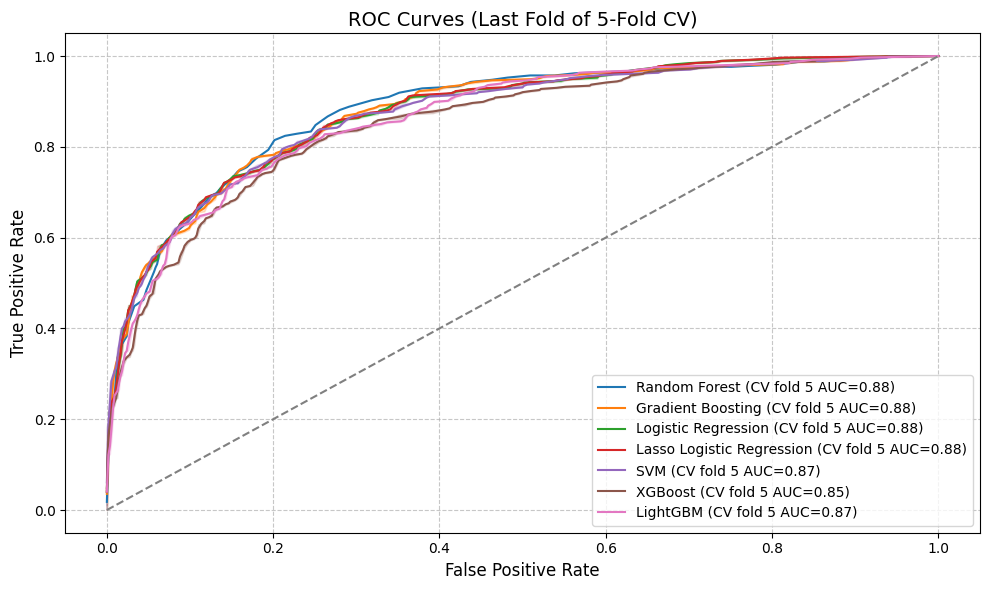

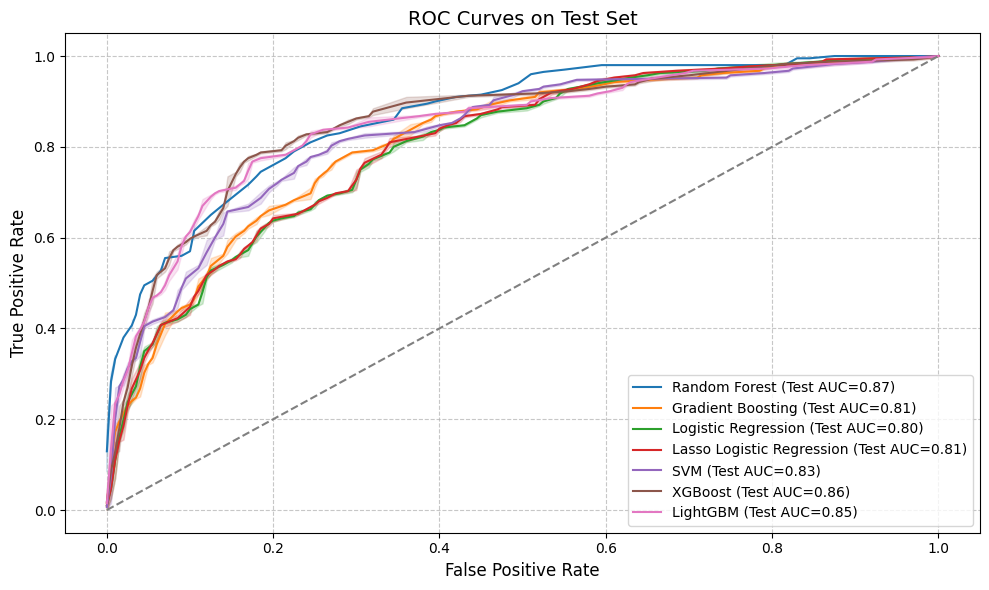

                       Model  CV Accuracy Mean  CV Accuracy Std  CV AUC Mean  \
0              Random Forest          0.774703         0.009930     0.851611   
1          Gradient Boosting          0.786689         0.010824     0.862356   
2        Logistic Regression          0.793512         0.004550     0.868681   
3  Lasso Logistic Regression          0.793099         0.006196     0.869044   
4                        SVM          0.787722         0.007611     0.859917   
5                    XGBoost          0.771805         0.009829     0.849304   
6                   LightGBM          0.782969         0.006601     0.857685   

   Test Accuracy  Test AUC  
0         0.7650  0.867762  
1         0.7250  0.813775  
2         0.7000  0.802450  
3         0.7000  0.805525  
4         0.7450  0.830325  
5         0.7700  0.855575  
6         0.7825  0.849225  


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
%matplotlib inline


#Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol']
BP_features = ['bp_sys']
heart_ch2_pca_features = [f'pca_embedding0_{i}' for i in range(1, 11)]
heart_ch3_pca_features = [f'pca_embedding1_{i}' for i in range(1, 11)]
heart_ch4_pca_features = [f'pca_embedding2_{i}' for i in range(1, 11)]
liver_features = [f'pca_embedding_liver_{i}' for i in range(1, 11)]
pancreas_features = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
dxa_features = [f'pca_embedding_dxa_{i}' for i in range(1, 11)]
PRS = ['PRS']
ECG = ['QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval', 'PPInterval', 'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude']
# heart_blood_flow = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
heart_aortic = [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
socio_economic_features = ['income', 'tnsi']
Diabetes_Mellitus = ['DM', 'HT', 'HL']

heart_long_axis = heart_ch2_pca_features + heart_ch3_pca_features +heart_ch4_pca_features

all_features = baseline_features + metabolic_features + heart_long_axis + PRS +ECG +  heart_aortic + Diabetes_Mellitus + socio_economic_features + liver_features + pancreas_features +dxa_features
# ------------------------------------------------------------------------------
# 1. Prepare data (ensure train and test DataFrames are loaded with same structure)
# ------------------------------------------------------------------------------
# Separate features and target
train = pd.read_csv('tabpfn_train.csv')
test = pd.read_csv('tabpfn_test.csv')
X_train = train[all_features]
y_train = train['label']
X_test = test[X_train.columns]
y_test = test['label']

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Select the top 60 features if needed (here we assume X_train.columns are already top 60)
selected_features = X_train.columns  # Replace with your actual top 60 features if different
X_train_scaled_selected = pd.DataFrame(X_train_scaled, columns=X_train.columns)[selected_features]
X_test_scaled_selected = pd.DataFrame(X_test_scaled, columns=X_train.columns)[selected_features]

# ------------------------------------------------------------------------------
# 2. Define models
# ------------------------------------------------------------------------------
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# ------------------------------------------------------------------------------
# 3. Cross-validation setup
# ------------------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

# ------------------------------------------------------------------------------
# 4. Compare models using cross-validation AND final test metrics
# ------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))

for model_name, model in models.items():
    # Lists to store metrics for cross-validation folds
    fold_accuracies = []
    fold_aucs = []
    
    # -- Cross-validation loop --
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled_selected, y_train)):
        X_train_cv = X_train_scaled_selected.iloc[train_idx]
        X_val_cv = X_train_scaled_selected.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train model on CV fold
        model.fit(X_train_cv, y_train_cv)

        # Predict on validation fold
        y_pred_val = model.predict(X_val_cv)
        
        # Predict probabilities if available (for AUC)
        if hasattr(model, "predict_proba"):
            y_pred_val_proba = model.predict_proba(X_val_cv)[:, 1]
        else:
            # If model doesn't support predict_proba (e.g., some SVM kernels), set to None
            y_pred_val_proba = None

        # Compute metrics for this fold
        acc_val = accuracy_score(y_val_cv, y_pred_val)
        auc_val = roc_auc_score(y_val_cv, y_pred_val_proba) if y_pred_val_proba is not None else 0

        fold_accuracies.append(acc_val)
        fold_aucs.append(auc_val)

        # For illustration: plot the ROC curve for the **last fold** only
        # (You can change to fold_idx == 0 or any condition you prefer.)
        if fold_idx == cv.n_splits - 1 and y_pred_val_proba is not None:
            fpr, tpr, _ = roc_curve(y_val_cv, y_pred_val_proba)
            sns.lineplot(x=fpr, y=tpr, label=f"{model_name} (CV fold {fold_idx+1} AUC={auc_val:.2f})")
    
    # -- Aggregate CV metrics --
    mean_acc_cv = np.mean(fold_accuracies)
    std_acc_cv = np.std(fold_accuracies)
    mean_auc_cv = np.mean(fold_aucs)

    # -- Retrain on full training set to evaluate on test data --
    model.fit(X_train_scaled_selected, y_train)
    y_pred_test = model.predict(X_test_scaled_selected)
    if hasattr(model, "predict_proba"):
        y_pred_test_proba = model.predict_proba(X_test_scaled_selected)[:, 1]
    else:
        y_pred_test_proba = None

    test_acc = accuracy_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test_proba) if y_pred_test_proba is not None else 0

    results.append({
        "Model": model_name,
        "CV Accuracy Mean": mean_acc_cv,
        "CV Accuracy Std": std_acc_cv,
        "CV AUC Mean": mean_auc_cv,
        "Test Accuracy": test_acc,
        "Test AUC": test_auc
    })

# Final formatting for CV ROC curve
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curves (Last Fold of 5-Fold CV)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 5. (Optional) Plot ROC on the test set for each model
# ------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
for res in results:
    model_name = res['Model']
    # Re-fetch the model to ensure it's the one trained on the full training set
    model = models[model_name]
    
    if hasattr(model, "predict_proba"):
        y_test_pred_proba = model.predict_proba(X_test_scaled_selected)[:, 1]
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
        sns.lineplot(x=fpr_test, y=tpr_test, label=f"{model_name} (Test AUC={res['Test AUC']:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curves on Test Set', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 6. Display results in a DataFrame
# ------------------------------------------------------------------------------
results_df = pd.DataFrame(results)
print(results_df)

In [53]:
results_df

,Model,CV Accuracy Mean,CV Accuracy Std,CV AUC Mean,Test Accuracy,Test AUC
0,Random Forest,0.773876,0.012791,0.851712,0.7650,0.873725
1,Gradient Boosting,0.786482,0.007882,0.862530,0.7075,0.814775
2,Logistic Regression,0.793512,0.004550,0.868689,0.7000,0.802475
3,Lasso Logistic Regression,0.793099,0.006196,0.869054,0.7000,0.805575
4,SVM,0.787722,0.007611,0.859923,0.7450,0.830450
5,XGBoost,0.777180,0.004835,0.849070,0.7900,0.860550
6,LightGBM,0.779866,0.006612,0.858332,0.7600,0.846825


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------------------------
# 1. Define feature groups
# ------------------------------------------------------------------------------
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol']
BP_features = ['bp_sys']
heart_ch2_pca_features = [f'pca_embedding0_{i}' for i in range(1, 11)]
heart_ch3_pca_features = [f'pca_embedding1_{i}' for i in range(1, 11)]
heart_ch4_pca_features = [f'pca_embedding2_{i}' for i in range(1, 11)]
liver_features = [f'pca_embedding_liver_{i}' for i in range(1, 11)]
pancreas_features = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
dxa_features = [f'pca_embedding_dxa_{i}' for i in range(1, 11)]
PRS = ['PRS']
ECG = ['QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval', 'PPInterval', 
       'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude']
heart_aortic = [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
socio_economic_features = ['income', 'tnsi']
Diabetes_Mellitus = ['DM']

heart_long_axis = heart_ch2_pca_features + heart_ch3_pca_features + heart_ch4_pca_features

all_features = (baseline_features + metabolic_features + heart_long_axis + PRS + ECG +
                heart_aortic + Diabetes_Mellitus + socio_economic_features +
                liver_features + pancreas_features + dxa_features)

# ------------------------------------------------------------------------------
# 2. Prepare data (ensure train and test DataFrames have the same structure)
# ------------------------------------------------------------------------------
# Load training and test data
train = pd.read_csv('tabpfn_train.csv')
test = pd.read_csv('tabpfn_test.csv')

# Separate features and target
X_train = train[all_features]
y_train = train['label']
X_test = test[X_train.columns]
y_test = test['label']

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assuming selected_features are already the ones you want (here we use all features)
selected_features = X_train.columns  
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)[selected_features]
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)[selected_features]

# ------------------------------------------------------------------------------
# 3. Define models
# ------------------------------------------------------------------------------
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', random_state=42, max_iter=1000),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# ------------------------------------------------------------------------------
# 4. Cross-validation and model evaluation
# ------------------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store CV and test results
cv_results = []    # per-fold CV metrics
test_results = []  # final test metrics per model

for model_name, model in models.items():
    fold_accuracies = []
    fold_aucs = []
    
    # Cross-validation loop
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled_df, y_train)):
        X_train_cv = X_train_scaled_df.iloc[train_idx]
        X_val_cv = X_train_scaled_df.iloc[val_idx]
        y_train_cv = y_train.iloc[train_idx]
        y_val_cv = y_train.iloc[val_idx]
        
        # Train model on CV fold
        model.fit(X_train_cv, y_train_cv)
        
        # Predict on validation fold
        y_pred_cv = model.predict(X_val_cv)
        if hasattr(model, "predict_proba"):
            y_pred_cv_proba = model.predict_proba(X_val_cv)[:, 1]
        else:
            y_pred_cv_proba = None
        
        # Compute metrics for this fold
        acc_cv = accuracy_score(y_val_cv, y_pred_cv)
        auc_cv = roc_auc_score(y_val_cv, y_pred_cv_proba) if y_pred_cv_proba is not None else 0
        
        fold_accuracies.append(acc_cv)
        fold_aucs.append(auc_cv)
        
        # Save per-fold CV results for later plotting in R
        cv_results.append({
            "Model": model_name,
            "Fold": fold_idx + 1,
            "CV_AUC": auc_cv,
            "CV_Accuracy": acc_cv
        })
    
    # Retrain on full training set and evaluate on test set
    model.fit(X_train_scaled_df, y_train)
    y_pred_test = model.predict(X_test_scaled_df)
    if hasattr(model, "predict_proba"):
        y_pred_test_proba = model.predict_proba(X_test_scaled_df)[:, 1]
    else:
        y_pred_test_proba = None
    
    test_acc = accuracy_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test_proba) if y_pred_test_proba is not None else 0
    
    test_results.append({
        "Model": model_name,
        "Test_AUC": test_auc,
        "Test_Accuracy": test_acc
    })

# Convert results to DataFrames
cv_results_df = pd.DataFrame(cv_results)
test_results_df = pd.DataFrame(test_results)

# ------------------------------------------------------------------------------
# 5. Save results to CSV for R plotting
# ------------------------------------------------------------------------------
cv_results_df.to_csv('cv_results.csv', index=False)
test_results_df.to_csv('test_results.csv', index=False)

print("CV results saved to 'cv_results.csv'")
print("Test results saved to 'test_results.csv'")


/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[LightGBM] [Info] Number of positive: 1686, number of negative: 2184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20841
[LightGBM] [Info] Number of data points in the train set: 3870, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435659 -> initscore=-0.258799
[LightGBM] [Info] Start training from score -0.258799
[LightGBM] [Info] Number of positive: 1686, number of negative: 2184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20838
[LightGBM] [Info] Number of data points in the train set: 3870, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435659 -> initscore=-0.258799
[Light

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# ------------------------------------------------------------------------------
# 1. Define feature groups
# ------------------------------------------------------------------------------
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol']
socio_economic_features = ['income', 'tnsi']
BP_features = ['bp_sys', 'bp_dia', 'pulse_rate']
heart_imaging_features = [f'pca_embedding0_{i}' for i in range(1, 11)] + \
                         [f'pca_embedding1_{i}' for i in range(1, 11)] + \
                         [f'pca_embedding2_{i}' for i in range(1, 11)] + \
                         [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
prs = ['PRS']




# ------------------------------------------------------------------------------
# 2. Load Data
# ------------------------------------------------------------------------------
train_comb = pd.read_csv('tabpfn_train.csv')

# Target variable
y = train_comb['label']

# ------------------------------------------------------------------------------
# 3. Train Logistic Regression with 5-Fold Cross-Validation
# ------------------------------------------------------------------------------
def train_logistic_cv(X, y):
    """Trains a Logistic Regression model with L1 regularization using 5-fold cross-validation 
    and returns the fold-wise effect sizes."""
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_coefs = []

    for train_idx, val_idx in cv.split(X_scaled, y):
        X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
        y_train_cv = y.iloc[train_idx]

        model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
        model.fit(X_train_cv, y_train_cv)
        all_coefs.append(model.coef_[0])  # Store coefficients for each fold

    all_coefs = np.array(all_coefs)  # Convert to numpy array for easier calculations
    return pd.DataFrame(all_coefs, columns=X.columns).mean()  # Returns mean effect sizes across 5 folds

# Train models separately for baseline & metabolic features
baseline_X = train_comb[baseline_features]
metabolic_X = train_comb[metabolic_features]

baseline_coefs = train_logistic_cv(baseline_X, y)
metabolic_coefs = train_logistic_cv(metabolic_X, y)

# Models after adding heart imaging
baseline_heart_X = train_comb[baseline_features + heart_imaging_features]
metabolic_heart_X = train_comb[metabolic_features + heart_imaging_features]

baseline_heart_coefs = train_logistic_cv(baseline_heart_X, y)
metabolic_heart_coefs = train_logistic_cv(metabolic_heart_X, y)

# ------------------------------------------------------------------------------
# 4. Fix Feature Alignment in DataFrame
# ------------------------------------------------------------------------------
# Create a unified feature list
all_features = baseline_features + metabolic_features

coef_df = pd.DataFrame({
    "Feature": all_features,
    "Baseline Only": baseline_coefs.reindex(baseline_features, fill_value=0).tolist() + [None] * len(metabolic_features),
    "Baseline + Heart Imaging": baseline_heart_coefs.reindex(baseline_features, fill_value=0).tolist() + [None] * len(metabolic_features),
    "Metabolic Only": [None] * len(baseline_features) + metabolic_coefs.reindex(metabolic_features, fill_value=0).tolist(),
    "Metabolic + Heart Imaging": [None] * len(baseline_features) + metabolic_heart_coefs.reindex(metabolic_features, fill_value=0).tolist()
})

# Melt DataFrame for CSV saving
coef_melted = coef_df.melt(id_vars=["Feature"], 
                           value_vars=["Baseline Only", "Baseline + Heart Imaging", 
                                       "Metabolic Only", "Metabolic + Heart Imaging"],
                           var_name="Model Type", value_name="Mean Coefficient")

# Save to CSV
coef_melted.to_csv("effect_sizes_for_R.csv", index=False)
print("CSV saved as 'effect_sizes_for_R.csv'")


CSV saved as 'effect_sizes_for_R.csv'


In [53]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import math

# ------------------------------------------------------------------------------
# 1. Define Feature Groups
# ------------------------------------------------------------------------------
baseline_features = ['age', 'sex', 'bmi', 'smoking', 'center']
BP_features = ['bp_sys', 'bp_dia', 'pulse_rate']
metabolic_features = ['ldl', 'trig', 'total_cholestrol']
socio_economic_features = ['income', 'tnsi']

# Full set of individual features to loop over
individual_features = baseline_features + BP_features + metabolic_features + socio_economic_features

PRS = ['PRS']
heart_long_axis = (
    [f'pca_embedding0_{i}' for i in range(1, 11)] +
    [f'pca_embedding1_{i}' for i in range(1, 11)] +
    [f'pca_embedding2_{i}' for i in range(1, 11)] +
    [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

liver_features = [f'pca_embedding_liver_{i}' for i in range(1, 11)]
pancreas_features = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
dxa_features = [f'pca_embedding_dxa_{i}' for i in range(1, 11)]

# ------------------------------------------------------------------------------
# 2. Load Data
# ------------------------------------------------------------------------------
train_comb = pd.read_csv('tabpfn_train.csv')
y = train_comb['label']

# ------------------------------------------------------------------------------
# 3. Define Cross-Validation Training Function
# ------------------------------------------------------------------------------
def train_logistic_cv(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_coefs = []

    for train_idx, val_idx in cv.split(X_scaled, y):
        X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
        y_train_cv = y.iloc[train_idx]

        model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
        model.fit(X_train_cv, y_train_cv)
        all_coefs.append(model.coef_[0])

    all_coefs = np.array(all_coefs)
    coef_df = pd.DataFrame(all_coefs, columns=X.columns)
    mean_coefs = coef_df.mean()
    se_coefs = coef_df.std() / math.sqrt(cv.get_n_splits())
    return mean_coefs, se_coefs

# ------------------------------------------------------------------------------
# 4. Evaluate Individual Features Across Model Types
# ------------------------------------------------------------------------------
results = []

model_configs = {
    "Base": [],
    "Base + PRS": PRS,
    "Base + Heart Imaging": heart_long_axis,
    "Base + Liver Imaging": liver_features,
    "Base + Pancreatic Imaging": pancreas_features,
    "Base + DXA Imaging": dxa_features
}

for feature in individual_features:
    for model_type, additional_feats in model_configs.items():
        input_features = [feature] + additional_feats
        X = train_comb[input_features]
        mean_coef, se_coef = train_logistic_cv(X, y)

        results.append({
            "Feature": feature,
            "Model Type": model_type,
            "Mean Coefficient": mean_coef[feature],
            "Std Error": se_coef[feature]
        })

# ------------------------------------------------------------------------------
# 5. Save Results
# ------------------------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("all_feature_effects_by_model_type.csv", index=False)
print("Saved: all_feature_effects_by_model_type.csv")


Saved: all_feature_effects_by_model_type.csv


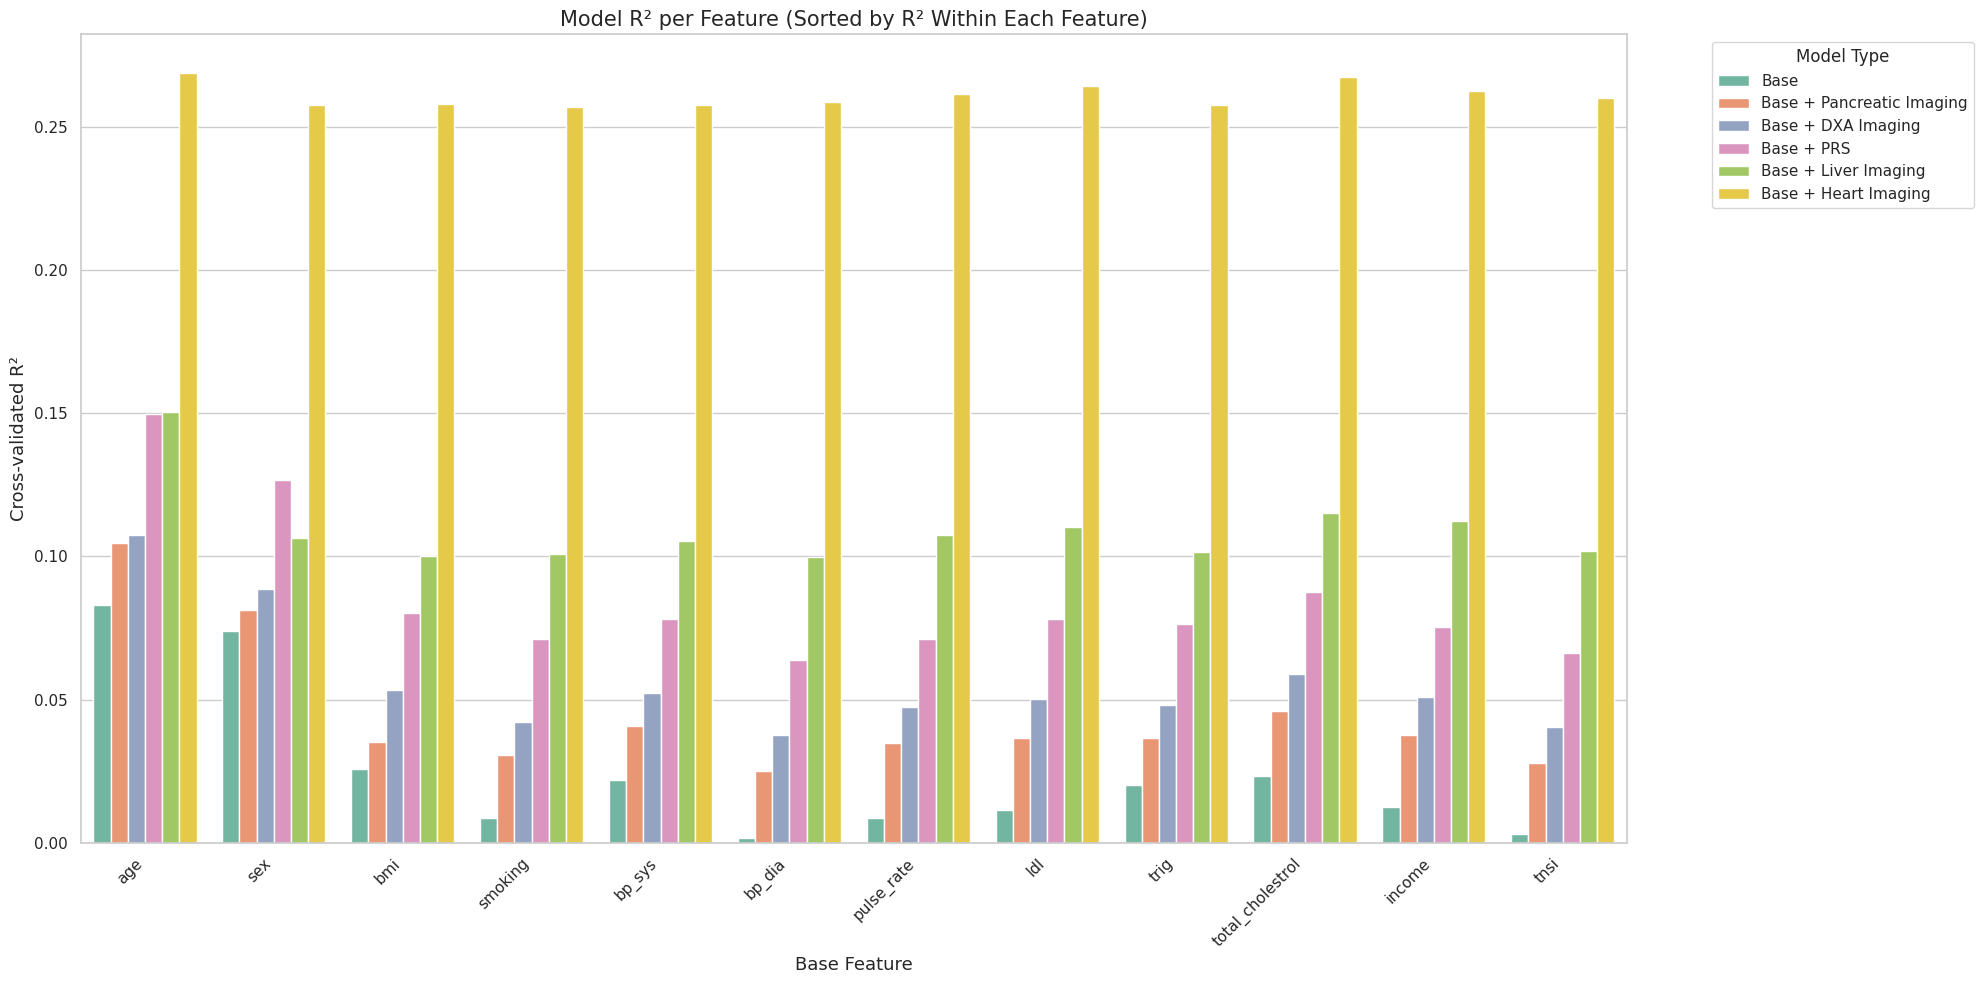

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
df = pd.read_csv("feature_r2_deltas.csv")

# Add Base R²
base_df = df[['Feature', 'Base R2']].drop_duplicates().copy()
base_df['Model Type'] = 'Base'
base_df['R2 with Modality'] = base_df['Base R2']
base_df['Delta R2'] = 0
base_df = base_df[['Feature', 'Model Type', 'Base R2', 'R2 with Modality', 'Delta R2']]

df_full = pd.concat([df, base_df], axis=0).reset_index(drop=True)

# Sort Model Types by R² within each feature group and assign new 'Sorted Model Type' label
df_full['Model Type (Sorted)'] = (
    df_full.groupby('Feature', group_keys=False)
    .apply(lambda g: g.sort_values('R2 with Modality')['Model Type'])
    .reset_index(drop=True)
)

# Set order for x-axis and hue
feature_order = df_full['Feature'].unique()
model_palette = sns.color_palette("Set2", n_colors=df_full['Model Type'].nunique())

# Plot
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")

ax = sns.barplot(
    data=df_full,
    x="Feature",
    y="R2 with Modality",
    hue="Model Type",
    hue_order=df_full.groupby('Feature')['R2 with Modality']
        .apply(lambda x: df_full.loc[x.index].sort_values('R2 with Modality')['Model Type'].tolist())
        .explode().drop_duplicates().tolist(),  # Unique hue order flattened
    order=feature_order,
    palette="Set2",
    dodge=True
)

# Aesthetics
plt.xticks(rotation=45, ha='right')
plt.title("Model R² per Feature (Sorted by R² Within Each Feature)", fontsize=15)
plt.xlabel("Base Feature", fontsize=13)
plt.ylabel("Cross-validated R²", fontsize=13)
plt.legend(title="Model Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [58]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol']
BP_features = ['bp_sys', 'bp_dia', 'pulse_rate']
heart_ch2_pca_features = [f'pca_embedding0_{i}' for i in range(1, 11)]
heart_ch3_pca_features = [f'pca_embedding1_{i}' for i in range(1, 11)]
heart_ch4_pca_features = [f'pca_embedding2_{i}' for i in range(1, 11)]
liver_features = [f'pca_embedding_liver_{i}' for i in range(1, 11)]
pancreas_features = [f'pca_embedding_pan_{i}' for i in range(1, 11)]
dxa_features = [f'pca_embedding_dxa_{i}' for i in range(1, 11)]
PRS = ['PRS']
ECG = ['QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval', 'PPInterval', 'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude']
heart_blood_flow = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
heart_aortic = [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
socio_economic_features = ['income', 'tnsi']
Diabetes_Mellitus = ['DM']
heart_long_axis = heart_ch2_pca_features + heart_ch3_pca_features + heart_ch4_pca_features
BP_combined_features = BP_features

# Full feature list
all_features = (baseline_features + metabolic_features + heart_long_axis + PRS + BP_combined_features +
                liver_features + dxa_features + pancreas_features + ECG + heart_blood_flow + heart_aortic +
                socio_economic_features + Diabetes_Mellitus)

# Load data
test = pd.read_csv('tabpfn_test.csv')
train = pd.read_csv('tabpfn_train.csv')
train = train.loc[~train['IID'].isin(test['IID'])]


# Target variable
y_train = train['label']

# Standardize all features (required before slicing groups)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(train[all_features]), columns=all_features)

# Function to calculate R² with bootstrapping
def bootstrap_r2_single_group(X, y, n_bootstraps=100):
    r2_scores = []
    sss = StratifiedShuffleSplit(n_splits=n_bootstraps, test_size=0.2, random_state=42)
    
    for train_idx, _ in sss.split(X, y):
        X_resampled = X.iloc[train_idx]
        y_resampled = y.iloc[train_idx]

        model = LassoCV(cv=5, random_state=42)
        r2 = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='r2').mean()
        r2_scores.append(r2)
        
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    ci_low = np.percentile(r2_scores, 2.5)
    ci_high = np.percentile(r2_scores, 97.5)
    
    return mean_r2, std_r2, ci_low, ci_high

# Feature groups to evaluate
feature_groups = [
    (baseline_features, 'Baseline'),
    (metabolic_features, 'Metabolic'),
    (PRS, 'PRS'),
    (socio_economic_features, 'Socio-Economic'),
    (heart_long_axis, 'Heart_LA-Imaging'),
    (liver_features, 'Liver-Imaging'),
    (pancreas_features, 'Pancreatic-Imaging'),
    (BP_combined_features, 'BP'),
    (dxa_features, 'DXA-Imaging'),
    (heart_blood_flow, 'Heart_BF-Imaging'),
    (heart_aortic, 'Heart_AD-Imaging'),
    (ECG, 'ECG'),
    (Diabetes_Mellitus, 'Diabetes'),
]

# Run R² calculation per group
results = []
for group, label in feature_groups:
    X_group = X_train_scaled[group]
    mean_r2, std_r2, ci_low, ci_high = bootstrap_r2_single_group(X_group, y_train)
    results.append((label, mean_r2, std_r2, ci_low, ci_high))

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Feature Group', 'R2 Mean', 'R2 Std', '95% CI Low', '95% CI High'])

# Display
print(results_df)

         Feature Group   R2 Mean    R2 Std  95% CI Low  95% CI High
0             Baseline  0.155589  0.004830    0.146747     0.164593
1            Metabolic  0.057193  0.003626    0.050248     0.064265
2                  PRS  0.061627  0.003584    0.054308     0.067825
3       Socio-Economic  0.013108  0.001957    0.008818     0.016582
4     Heart_LA-Imaging  0.220006  0.005013    0.210174     0.227846
5        Liver-Imaging  0.090010  0.004387    0.081703     0.097905
6   Pancreatic-Imaging  0.070800  0.004111    0.062731     0.078909
7                   BP  0.033380  0.002743    0.027847     0.038110
8          DXA-Imaging  0.029631  0.003450    0.023045     0.035468
9     Heart_BF-Imaging  0.103972  0.004498    0.093223     0.112260
10    Heart_AD-Imaging  0.152749  0.004788    0.143491     0.162149
11                 ECG  0.040572  0.003707    0.033364     0.046383
12            Diabetes  0.035773  0.002541    0.030420     0.040009


In [1]:
import numpy as np
import pandas as pd
import itertools
from sklearn.linear_model import LinearRegression  # using OLS for speed in analysis
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Define feature groups (example)
# -------------------------------
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol']
BP_features = ['bp_sys', 'bp_dia', 'pulse_rate']
heart_ch2_pca_features = [f'pca_embedding0_{i}' for i in range(1, 11)]
heart_ch3_pca_features = [f'pca_embedding1_{i}' for i in range(1, 11)]
heart_ch4_pca_features = [f'pca_embedding2_{i}' for i in range(1, 11)]
liver_features = [f'pca_embedding_liver_{i}' for i in range(1, 11)]
pancreas_features = [f'pca_embedding_pan_{i}' for i in range(1, 11)]
dxa_features = [f'pca_embedding_dxa_{i}' for i in range(1, 11)]
PRS = ['PRS']
ECG = ['QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval', 'PPInterval', 
       'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude']
heart_blood_flow = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
heart_aortic = [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
socio_economic_features = ['income', 'tnsi']
Diabetes_Mellitus = ['DM']

# Combine PCA features into larger groups
heart_long_axis = heart_ch2_pca_features + heart_ch3_pca_features + heart_ch4_pca_features
BP_combined_features = BP_features

# Full feature set remains as before
all_features = (baseline_features + metabolic_features + heart_long_axis + PRS + BP_combined_features +
                liver_features + dxa_features + pancreas_features + ECG + heart_blood_flow + heart_aortic +
                socio_economic_features + Diabetes_Mellitus)

# List of feature groups as tuples: (list_of_features, group_label)
feature_groups = [
    (baseline_features, 'Baseline'),
    (metabolic_features, 'Metabolic'),
    (PRS, 'PRS'),
    (socio_economic_features, 'Socio-Economic'),
    (heart_long_axis, 'Heart_LA-Imaging'),
    (liver_features, 'Liver-Imaging'),
    (pancreas_features, 'Pancreatic-Imaging'),
    (BP_combined_features, 'BP'),
    (dxa_features, 'DXA-Imaging'),
    (heart_blood_flow, 'Heart_BF-Imaging'),
    (heart_aortic, 'Heart_AD-Imaging'),
    (ECG, 'ECG'),
    (Diabetes_Mellitus, 'Diabetes'),
]

# -------------------------------
# Load and standardize the data
# -------------------------------
train = pd.read_csv('tabpfn_train.csv')
test = pd.read_csv('tabpfn_test.csv')



X_train = train[all_features]
y_train = train['label']

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# -------------------------------
# Compute R² for all subsets (as before)
# -------------------------------
model = LinearRegression()
n_groups = len(feature_groups)
subset_r2 = {}
subset_r2[()] = 0.0  # define R² for empty set as 0

def compute_subset_r2(subset_indices):
    features = []
    for idx in subset_indices:
        features.extend(feature_groups[idx][0])
    if len(features) == 0:
        return 0.0
    X_subset = X_train_scaled[features]
    y_pred = cross_val_predict(model, X_subset, y_train, cv=3)
    return r2_score(y_train, y_pred)

for r in range(1, n_groups + 1):
    for subset in itertools.combinations(range(n_groups), r):
        subset = tuple(sorted(subset))
        subset_r2[subset] = compute_subset_r2(subset)

# -------------------------------
# Perform Commonality Analysis
# -------------------------------
# For every non-empty subset S, compute:
# c_S = sum_{T ⊆ S} (-1)^(|S|-|T|) * R²(T)
commonality = {}
for subset in subset_r2.keys():
    if len(subset) == 0:
        continue  # Skip the empty set
    c = 0.0
    # Iterate over all subsets T of S
    for r in range(len(subset) + 1):
        for T in itertools.combinations(subset, r):
            sign = (-1) ** (len(subset) - len(T))
            c += sign * subset_r2[T]
    commonality[subset] = c

# Convert the commonality coefficients into a DataFrame for presentation
rows = []
for subset, c_val in commonality.items():
    groups = [feature_groups[i][1] for i in subset]
    rows.append({
        "Feature Groups": ", ".join(groups),
        "Commonality Coefficient": c_val
    })

commonality_df = pd.DataFrame(rows)
commonality_df = commonality_df.sort_values(by="Commonality Coefficient", ascending=False)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
commonality_df.head()

,Feature Groups,Commonality Coefficient
4,Heart_LA-Imaging,0.213496
0,Baseline,0.157686
10,Heart_AD-Imaging,0.152294
9,Heart_BF-Imaging,0.106153
126,"Baseline, Heart_LA-Imaging, Heart_AD-Imaging",0.101264


  Imaging Group     Combination  Commonality Coefficient
0           PRS           Alone                 0.063012
1           PRS   With Baseline                -0.016412
2           PRS  With Metabolic                -0.014596
3           PRS        With ECG                -0.005333
4           PRS   With Heart LA                -0.034255
5           PRS   With Heart AD                -0.025101
6           PRS   With Heart BF                -0.016107
7           PRS      With Liver                -0.016314
8           PRS   With Pancreas                -0.011693
9           PRS        With DXA                -0.004394


TypeError: 'Axes' object is not iterable

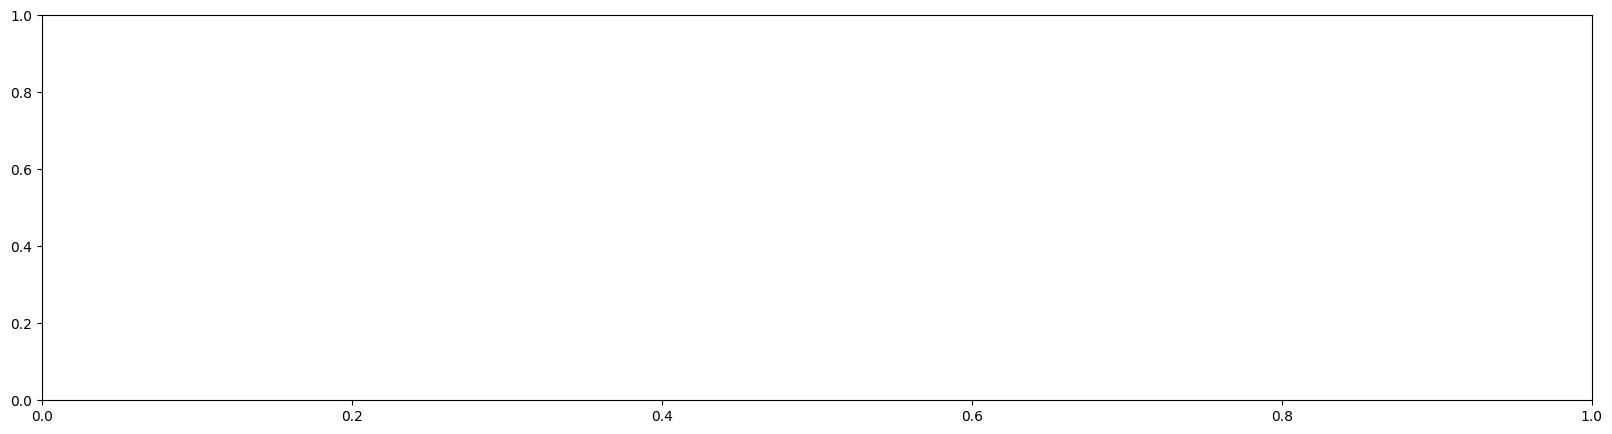

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# --- Assume commonality_df is already computed ---
# commonality_df is expected to have the columns:
#   "Feature Groups" (a string of comma-separated feature group labels)
#   "Commonality Coefficient" (the computed coefficient)

# For example, commonality_df might look like:
#    Feature Groups                       Commonality Coefficient
# 0  Liver-Imaging                        0.05
# 1  Baseline, Liver-Imaging              0.02
# 2  Liver-Imaging, Heart_LA-Imaging, Heart_AD-Imaging   -0.01
# ... and so on.

# Define the imaging groups we want to focus on:
imaging_groups = [ "PRS"]

# Define the target combinations for each imaging group.
# The imaging group in question is combined with:
# - Itself alone
# - It + Heart_LA-Imaging + Heart_AD-Imaging
# - It + Baseline
# - It + PRS
# - It + Metabolic
def get_target_combinations(imaging):
    return {
        "Alone": [imaging],
        "With Baseline": [imaging, "Baseline"],
        "With Metabolic": [imaging, "Metabolic"],
        "With ECG" :[imaging, "ECG"],
        "With Heart LA" :[imaging, "Heart_LA-Imaging"],
        "With Heart AD" :[imaging, "Heart_AD-Imaging"],
        "With Heart BF" :[imaging, "Heart_BF-Imaging"],
        "With Liver" :[imaging,  "Liver-Imaging"],
        "With Pancreas" :[imaging,  "Pancreatic-Imaging"],
        "With DXA" :[imaging, "DXA-Imaging"]
        
    }

# Function to look up the commonality coefficient in commonality_df for an exact combination.
def find_commonality(coefficient_df, target_list):
    target_set = set(target_list)
    for idx, row in coefficient_df.iterrows():
        groups = [g.strip() for g in row["Feature Groups"].split(",") if g.strip()]
        if set(groups) == target_set:
            return row["Commonality Coefficient"]
    return np.nan  # if not found

# For each imaging group, gather the commonality coefficients for the target combinations.
results = []
for imaging in imaging_groups:
    combos = get_target_combinations(imaging)
    for combo_label, combo_list in combos.items():
        coeff = find_commonality(commonality_df, combo_list)
        results.append({
            "Imaging Group": imaging,
            "Combination": combo_label,
            "Commonality Coefficient": coeff
        })

results_df = pd.DataFrame(results)
print(results_df)

# --- Plotting ---
# Create a subplot for each imaging group.
fig, axes = plt.subplots(1, len(imaging_groups), figsize=(20, 5), sharey=True)

for ax, imaging in zip(axes, imaging_groups):
    data = results_df[results_df["Imaging Group"] == imaging]
    # Create a bar plot for the combinations
    ax.bar(data["Combination"], data["Commonality Coefficient"], color='skyblue')
    ax.set_title(imaging)
    ax.set_xlabel("Combination")
    ax.set_xticklabels(data["Combination"], rotation=45, ha='right')
    ax.grid(axis='y')
    
axes[0].set_ylabel("Commonality Coefficient")
plt.tight_layout()
plt.show()

C-index per imaging center (5-fold CV):
Reading: 0.823
Bristol: 0.842
Cheadle: 0.806
Newcastle: 0.810


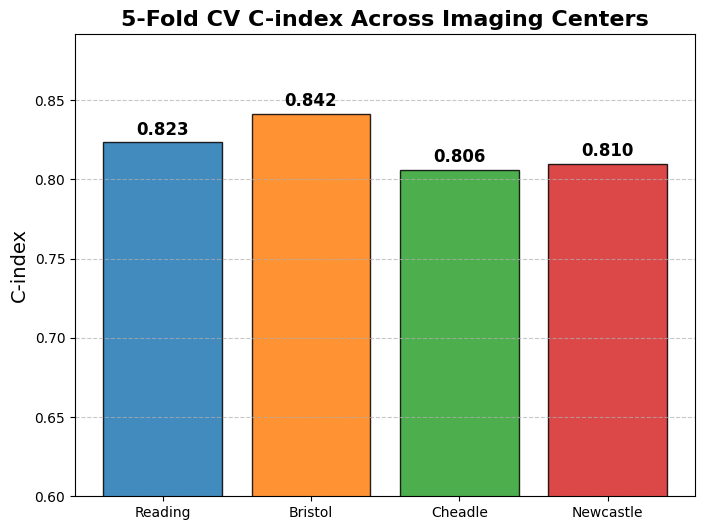

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# ------------------------------------------------------------------------------
# 1. Load Data and Add Imaging Center Information
# ------------------------------------------------------------------------------
cox_train = pd.read_csv('cox_train.csv')
cox_test = pd.read_csv('cox_test.csv')

# Load and merge center information
center = pd.read_csv('/corral/utexas/UKB-Imaging-Genetics/temp_imaging_data/pheno_split_into_files_011924/fid54.csv')\
            .rename(columns={'eid': 'IID', '54-2.0': 'center'})[['IID', 'center']]
center = center.dropna()

cox_train = pd.merge(cox_train, center, on='IID', how='inner')
cox_test = pd.merge(cox_test, center, on='IID', how='inner')

# Map center codes to names
center_names = {
    11025.0: "Cheadle",
    11026.0: "Reading",
    11027.0: "Newcastle",
    11028.0: "Bristol"
}
cox_train['center_name'] = cox_train['center'].map(center_names)
cox_test['center_name'] = cox_test['center'].map(center_names)

# ------------------------------------------------------------------------------
# 2. Define Model Features and Standardize Numeric Variables
# ------------------------------------------------------------------------------
# Define feature groups for your model (Framingham part removed)
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']
heart_imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)] +
    [f'pca_embedding1_{i}' for i in range(1, 11)] +
    [f'pca_embedding2_{i}' for i in range(1, 11)] +
    [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)
your_model_features = baseline_features + metabolic_features + PRS + heart_imaging_features

# Select features for scaling
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol', 'PRS'] + heart_imaging_features

scaler = StandardScaler()
cox_train[features_to_scale] = scaler.fit_transform(cox_train[features_to_scale])
cox_test[features_to_scale] = scaler.transform(cox_test[features_to_scale])

# ------------------------------------------------------------------------------
# 3. 5-Fold Cross-Validation with CoxPH and Compute c-index per Imaging Center
# ------------------------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# DataFrame to store out-of-fold predictions
oof_preds = pd.DataFrame(index=cox_train.index)
oof_preds['time_at_risk'] = cox_train['time_at_risk']
oof_preds['event'] = cox_train['event']
oof_preds['center_name'] = cox_train['center_name']
oof_preds['predicted_risk'] = np.nan

# Perform 5-fold CV
for train_idx, test_idx in kf.split(cox_train):
    train_fold = cox_train.iloc[train_idx]
    test_fold = cox_train.iloc[test_idx]
    
    cph = CoxPHFitter()
    cph.fit(train_fold[your_model_features + ['time_at_risk', 'event']],
            duration_col='time_at_risk', event_col='event')
    
    # Obtain predicted relative risk (partial hazard) for the test fold
    test_fold_pred = cph.predict_partial_hazard(test_fold[your_model_features])
    
    oof_preds.loc[test_idx, 'predicted_risk'] = test_fold_pred.values

# Compute c-index per imaging center (note: higher predicted risk indicates higher hazard;
# we use the negative risk for concordance_index so that higher risk corresponds to shorter survival)
center_c_indices = {}
for center in oof_preds['center_name'].unique():
    center_data = oof_preds[oof_preds['center_name'] == center]
    c_index = concordance_index(center_data['time_at_risk'], -center_data['predicted_risk'], center_data['event'])
    center_c_indices[center] = c_index

# Print the results
print("C-index per imaging center (5-fold CV):")
for center, c_index in center_c_indices.items():
    print(f"{center}: {c_index:.3f}")

# ------------------------------------------------------------------------------
# 4. Plot the c-index Results per Imaging Center
# ------------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
centers_sorted = list(center_c_indices.keys())
c_indices_sorted = [center_c_indices[c] for c in centers_sorted]
bars = plt.bar(centers_sorted, c_indices_sorted, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], 
               alpha=0.85, edgecolor='black')

# Add value labels above bars
for bar, c_index in zip(bars, c_indices_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f"{c_index:.3f}", ha='center', fontsize=12, fontweight='bold')

plt.ylabel('C-index', fontsize=14)
plt.title('5-Fold CV C-index Across Imaging Centers', fontsize=16, fontweight='bold')
plt.ylim(0.6, max(c_indices_sorted) + 0.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

PermutationExplainer explainer: 5139it [01:25, 58.63it/s]                          


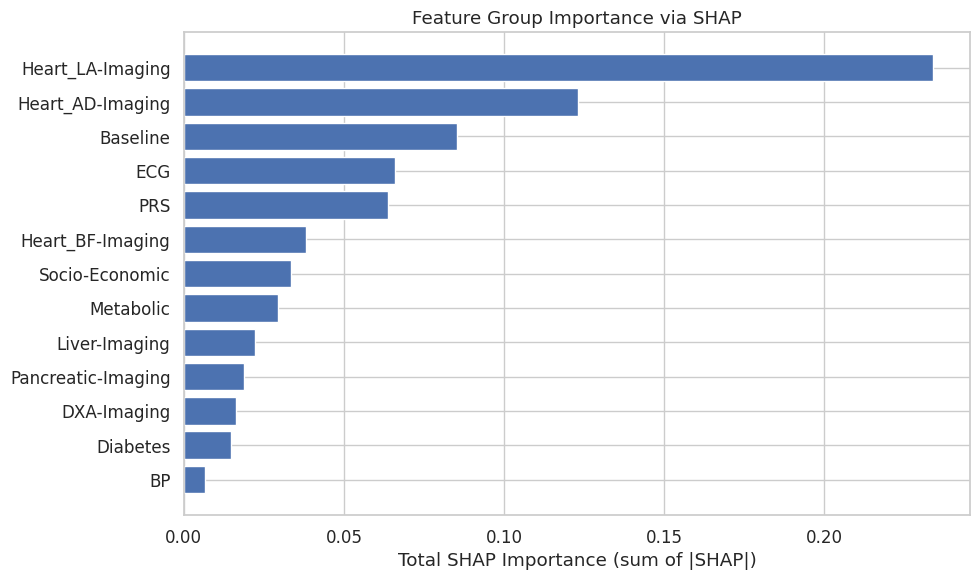

In [60]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
%matplotlib inline

# --- Feature Group Definitions ---

baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol']
BP_features = ['bp_sys', 'bp_dia', 'pulse_rate']
heart_ch2_pca_features = [f'pca_embedding0_{i}' for i in range(1, 11)]
heart_ch3_pca_features = [f'pca_embedding1_{i}' for i in range(1, 11)]
heart_ch4_pca_features = [f'pca_embedding2_{i}' for i in range(1, 11)]
liver_features = [f'pca_embedding_liver_{i}' for i in range(1, 11)]
pancreas_features = [f'pca_embedding_pan_{i}' for i in range(1, 11)]
dxa_features = [f'pca_embedding_dxa_{i}' for i in range(1, 11)]
PRS = ['PRS']
ECG = ['QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval', 'PPInterval', 'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude']
heart_blood_flow = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
heart_aortic = [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
socio_economic_features = ['income', 'tnsi']
Diabetes_Mellitus = ['DM']

heart_long_axis = heart_ch2_pca_features + heart_ch3_pca_features + heart_ch4_pca_features
BP_combined_features = BP_features

# Combine all features
all_features = (baseline_features + metabolic_features + heart_long_axis + PRS + BP_combined_features +
                liver_features + dxa_features + pancreas_features + ECG + heart_blood_flow + heart_aortic +
                socio_economic_features + Diabetes_Mellitus)

# Group dictionary for aggregation
feature_groups_dict = {
    'Baseline': baseline_features,
    'Metabolic': metabolic_features,
    'PRS': PRS,
    'Socio-Economic': socio_economic_features,
    'Heart_LA-Imaging': heart_long_axis,
    'Liver-Imaging': liver_features,
    'Pancreatic-Imaging': pancreas_features,
    'BP': BP_combined_features,
    'DXA-Imaging': dxa_features,
    'Heart_BF-Imaging': heart_blood_flow,
    'Heart_AD-Imaging': heart_aortic,
    'ECG': ECG,
    'Diabetes': Diabetes_Mellitus,
}

# --- Load and Prepare Data ---

test = pd.read_csv('tabpfn_test.csv')
train = pd.read_csv('tabpfn_train.csv')
train = train.loc[~train['IID'].isin(test['IID'])]
train_combined = pd.concat([train, test], axis=0, ignore_index=True)

X = train_combined[all_features]
y = train_combined['label']

# Standardize
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# --- Fit Lasso Model ---

model = LassoCV(cv=5, random_state=42)
model.fit(X_scaled, y)

# --- Compute SHAP Values ---

explainer = shap.Explainer(model.predict, X_scaled)
shap_values = explainer(X_scaled)

# --- SHAP Summary Plot (All Features) ---

# print("\n🔍 SHAP Summary Plot (Feature-level)")
# shap.summary_plot(shap_values, X_scaled, plot_type='bar')

# --- SHAP Group-Level Aggregation ---

shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({'Feature': X_scaled.columns, 'SHAP_Importance': shap_abs_mean})

group_shap_importance = {}
for group, features in feature_groups_dict.items():
    group_shap_importance[group] = shap_df[shap_df['Feature'].isin(features)]['SHAP_Importance'].sum()

group_shap_df = pd.DataFrame(group_shap_importance.items(), columns=['Feature Group', 'Total SHAP Importance'])
group_shap_df = group_shap_df.sort_values(by='Total SHAP Importance', ascending=False)

# --- Plot SHAP by Feature Group ---

plt.figure(figsize=(10, 6))
plt.barh(group_shap_df['Feature Group'], group_shap_df['Total SHAP Importance'])
plt.xlabel('Total SHAP Importance (sum of |SHAP|)')
plt.title('Feature Group Importance via SHAP')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Function to calculate R² and relative change with bootstrapping for error bars
def bootstrap_relative_change_r2(X_full, X_subset, y, model, r2_full, n_bootstraps=100):
    relative_change_bootstrap = []
    for _ in range(n_bootstraps):
        X_full_resampled, y_resampled = resample(X_full, y)
        X_subset_resampled = X_full_resampled[X_subset.columns]

        # Full model R²
        y_pred_full = cross_val_predict(model, X_full_resampled, y_resampled, cv=5)
        r2_full_resampled = r2_score(y_resampled, y_pred_full)

        # Subset model R²
        y_pred_subset = cross_val_predict(model, X_subset_resampled, y_resampled, cv=5)
        r2_subset_resampled = r2_score(y_resampled, y_pred_subset)

        # Calculate relative change
        relative_change = (r2_subset_resampled - r2_full_resampled) / r2_full_resampled * 100
        relative_change_bootstrap.append(relative_change)

    relative_change_mean = np.mean(relative_change_bootstrap)
    relative_change_err = np.std(relative_change_bootstrap)
    return relative_change_mean, relative_change_err

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol']
BP_features = ['bp_sys', 'bp_dia', 'pulse_rate']
heart_ch2_pca_features = [f'pca_embedding0_{i}' for i in range(1, 11)]
heart_ch3_pca_features = [f'pca_embedding1_{i}' for i in range(1, 11)]
heart_ch4_pca_features = [f'pca_embedding2_{i}' for i in range(1, 11)]
liver_features = [f'pca_embedding_liver_{i}' for i in range(1, 11)]
pancreas_features = [f'pca_embedding_pan_{i}' for i in range(1, 11)]
dxa_features = [f'pca_embedding_dxa_{i}' for i in range(1, 11)]
PRS = ['PRS']
ECG = ['QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval', 'PPInterval', 'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude']
heart_blood_flow = [f'pca_blood_flow_embeddings_{i}' for i in range(1, 11)]
heart_aortic = [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
socio_economic_features = ['income', 'tnsi']
Diabetes_Mellitus = ['DM']

# Combine PCA features into larger groups
heart_long_axis = heart_ch2_pca_features + heart_ch3_pca_features + heart_ch4_pca_features
BP_combined_features = BP_features

# Full feature set
all_features = (baseline_features + metabolic_features + heart_long_axis + PRS + BP_combined_features +
                liver_features + dxa_features + pancreas_features + ECG + heart_blood_flow + heart_aortic +
                socio_economic_features + Diabetes_Mellitus)

# Combine train and test for processing
train = pd.read_csv('tabpfn_train.csv')
test = pd.read_csv('tabpfn_test.csv')


# Extract features and labels
X_train = train[all_features]
y_train = train['label']

# Standardize features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Fit Lasso model
lasso_model = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
y_pred_full = cross_val_predict(lasso_model, X_train_scaled, y_train, cv=5)
r2_full = r2_score(y_train, y_pred_full)

# Function to calculate feature group effects
def remove_features_and_calculate(features_to_remove, feature_label):
    subset_features = [f for f in all_features if f not in features_to_remove]
    X_train_scaled_subset = X_train_scaled[subset_features]
    relative_change, relative_change_err = bootstrap_relative_change_r2(
        X_train_scaled, X_train_scaled_subset, y_train, lasso_model, r2_full
    )
    absolute_change = (relative_change / 100) * r2_full
    return feature_label, relative_change, absolute_change, relative_change_err

# List of feature groups to evaluate
feature_groups = [
    (baseline_features, 'Baseline'),
    (metabolic_features, 'Metabolic'),
    (PRS, 'PRS'),
    (socio_economic_features, 'Socio-Economic'),
    (heart_long_axis, 'Heart_LA-Imaging'),
    (liver_features, 'Liver-Imaging'),
    (pancreas_features, 'Pancreatic-Imaging'),
    (BP_combined_features, 'BP'),
    (dxa_features, 'DXA-Imaging'),
    (heart_blood_flow, 'Heart_BF-Imaging'),
    (heart_aortic, 'Heart_AD-Imaging'),
    (ECG, 'ECG'),
    (Diabetes_Mellitus, 'Diabetes'), 
]

# Calculate results for each feature group
results = []
for features, label in feature_groups:
    results.append(remove_features_and_calculate(features, label))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Feature Group', 'Relative Change (%)', 'Absolute Change', 'Error'])

# Display and save results/
print(results_df)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


         Feature Group  Relative Change (%)  Absolute Change     Error
0             Baseline            -2.843946        -0.008860  0.751948
1            Metabolic            -1.712070        -0.005334  0.548148
2                  PRS            -7.661694        -0.023869  1.177813
3       Socio-Economic            -1.644375        -0.005123  0.585517
4     Heart_LA-Imaging            -9.642647        -0.030041  1.285013
5        Liver-Imaging            -0.374803        -0.001168  0.419721
6   Pancreatic-Imaging            -0.283765        -0.000884  0.404489
7                   BP            -0.055048        -0.000171  0.214279
8          DXA-Imaging            -0.202873        -0.000632  0.409473
9     Heart_BF-Imaging            -0.685064        -0.002134  0.462793
10    Heart_AD-Imaging            -4.299687        -0.013395  0.976606
11                 ECG            -2.613651        -0.008143  0.757642
12            Diabetes            -1.174872        -0.003660  0.476573
